In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pydeseq2.default_inference
import pydeseq2.ds
import pydeseq2.dds

# Jump to top

In [2]:
###Define Thresholds

rare_species_abundance_threshold = 6.5
expressed_gene_reads_threshold = 2000
number_of_samples_expressed_in_threshold = 21

In [3]:
transcriptome = pd.read_csv(
    "/Users/michael/Data/Luke_terrace_experiment/General_data/plate1_4_tpm_normalized.csv",
    index_col=0,
)
rows_to_drop_expression_data = [
    "A2450525897_n01_undetermined",
    "A2449446903_n01_undetermined",
    "B250508004_n01_undetermined",
    "B2449500127_n01_undetermined",
]
transcriptome = transcriptome.drop(index=rows_to_drop_expression_data)
transcriptome = transcriptome.sort_index()

metadata = pd.read_csv(
    "/Users/michael/Data/Luke_terrace_experiment/General_data/Plates_1_to_4_metadata_merged_luke.csv",
    index_col=0,
)
metadata = pd.read_csv(
    "/Users/michael/Data/Luke_terrace_experiment/General_data/Plates_1_to_4_metadata_merged_luke.csv",
    index_col=0,
)
metadata = metadata.drop(
    columns=[
        "arb.sort",
        "sample-id",
        "Ambiguous Unstranded",
        "Ambiguous Forward",
        "Multimapping",
        "Unmapped Over Mapped",
    ]
)
metadata["Date and Time"] = metadata["date"] + " " + metadata["time"]
luke_time_data_format = "%-m/%-d/%y %-H:%-M"
metadata["Date and Time"] = pd.to_datetime(
    metadata["Date and Time"], format=luke_time_data_format
)

unusable_samples = [
    "A2450525897_n01_LICRNA01_A06",
    "A2450525897_n01_LICRNA01_A08",
    "A2450525897_n01_LICRNA01_C11",
    "A2450525897_n01_LICRNA01_D11",
    "A2450525897_n01_LICRNA01_D12",
    "A2449446903_n01_LICRNA02_F01",
    "B2449500127_n01_LICRNA04_A04",
    "B2449500127_n01_LICRNA04_A06",
    "B2449500127_n01_LICRNA04_A07",
]
borderline_unusable = [
    "A2450525897_n01_LICRNA01_F03",
    "A2450525897_n01_LICRNA01_G07",
    "A2449446903_n01_LICRNA02_A04",
    "A2449446903_n01_LICRNA02_H10",
    "B2449500127_n01_LICRNA04_H02",
    "B2449500127_n01_LICRNA04_H11",
]
all_unsable = borderline_unusable + unusable_samples

raw_transcriptome = pd.read_csv(
    "/Users/michael/Data/Luke_terrace_experiment/General_data/plate1_4_for_norm.csv",
    index_col=0,
)

trimmed_transcriptome = transcriptome.drop(index=all_unsable)
trimmed_metadata = metadata.drop(index=all_unsable)
trimmed_raw_transcriptome = raw_transcriptome.drop(index=all_unsable)
trimmed_metadata = trimmed_metadata.sort_index()
trimmed_transcriptome = trimmed_transcriptome.dropna(how="all", axis=0)
trimmed_transcriptome = trimmed_transcriptome.dropna(how="all", axis=1)

In [4]:
trimmed_transcriptome

,AT1G01010,AT1G01020,AT1G03987,AT1G01030,AT1G01040,AT1G03993,AT1G01046,AT1G01050,AT1G03997,AT1G01060,...,ArthCt124,ArthCr088,ArthCt112,ArthCp088,ArthCp086,ArthCt118,ArthCp083,ArthCt111,ArthCp084,ArthCp085
A2449446903_n01_LICRNA02_A01,0.382839,11.929183,0.0,3.731527,3.602189,0.0,0.0,31.063543,0.0,3.966935,...,17.950907,44.209074,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,6.266498
A2449446903_n01_LICRNA02_A02,0.000000,5.826682,0.0,1.501594,3.439569,0.0,0.0,22.712417,0.0,18.186693,...,1.986484,9.688606,0.0,5.501032,0.0,0.0,0.519342,0.0,0.000000,3.467317
A2449446903_n01_LICRNA02_A03,1.021565,7.683520,0.0,0.301733,2.700528,0.0,0.0,42.431625,0.0,12.937632,...,7.983340,16.384320,0.0,7.983340,0.0,0.0,0.166972,0.0,0.000000,0.000000
A2449446903_n01_LICRNA02_A05,0.732717,3.149144,0.0,1.947758,3.742586,0.0,0.0,26.541337,0.0,23.861601,...,17.178143,17.005325,0.0,0.000000,0.0,0.0,0.628742,0.0,0.000000,0.000000
A2449446903_n01_LICRNA02_A06,1.614233,1.238895,0.0,6.130092,4.215597,0.0,0.0,19.379509,0.0,5.006570,...,16.219201,43.599301,0.0,0.000000,0.0,0.0,1.074213,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B250508004_n01_LICRNA03_H08,0.074367,4.474710,0.0,1.383813,2.059206,0.0,0.0,27.907884,0.0,11.118408,...,3.486989,4.209645,0.0,1.072920,0.0,0.0,0.948096,0.0,0.000000,0.760798
B250508004_n01_LICRNA03_H09,2.232353,6.249002,0.0,1.873955,3.869254,0.0,0.0,40.686812,0.0,7.391606,...,9.640892,4.655562,0.0,5.085306,0.0,0.0,0.360071,0.0,1.758217,4.807925
B250508004_n01_LICRNA03_H10,0.000000,0.000000,0.0,0.000000,2.953706,0.0,0.0,36.084398,0.0,0.000000,...,0.000000,4.975538,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
B250508004_n01_LICRNA03_H11,0.678594,7.655887,0.0,0.901942,4.195848,0.0,0.0,54.077818,0.0,0.334834,...,0.000000,2.304762,0.0,0.000000,0.0,0.0,0.166371,0.0,0.000000,0.694222


In [5]:
trimmed_raw_transcriptome

,AT1G01010,AT1G01020,AT1G03987,AT1G01030,AT1G01040,AT1G03993,AT1G01046,AT1G01050,AT1G03997,AT1G01060,...,ArthCt124,ArthCr088,ArthCt112,ArthCp088,ArthCp086,ArthCt118,ArthCp083,ArthCt111,ArthCp084,ArthCp085
A2450525897_n01_LICRNA01_H06,0,48,0,34,111,0,0,343,0,198,...,5,53,1,29,0,0,30,0,0,6
A2450525897_n01_LICRNA01_F06,12,87,0,55,150,0,0,331,0,212,...,3,82,5,18,0,0,3,0,0,12
A2450525897_n01_LICRNA01_E01,19,27,0,22,41,0,0,135,0,89,...,0,44,0,0,0,0,3,0,0,5
A2450525897_n01_LICRNA01_H10,6,24,0,5,97,0,0,140,0,75,...,0,32,0,2,0,0,8,0,0,0
A2450525897_n01_LICRNA01_F10,6,42,0,6,85,0,0,215,0,69,...,0,15,0,9,0,0,4,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B2449500127_n01_LICRNA04_E07,6,59,0,7,103,0,0,206,0,53,...,0,22,0,14,0,0,1,0,0,3
B2449500127_n01_LICRNA04_F10,0,25,0,0,74,0,0,178,0,73,...,0,13,0,3,0,0,0,0,0,0
B2449500127_n01_LICRNA04_C01,0,20,0,15,64,0,0,99,0,4,...,0,7,0,5,0,0,1,0,0,20
B2449500127_n01_LICRNA04_D12,15,82,0,11,192,0,0,347,0,116,...,1,47,0,4,0,0,33,0,0,25


In [6]:
trimmed_metadata

,plate.pos,sampID,sample.type,timepoint,date,time,extractplate,rnaprepplate,Unmapped,No Feature,plate_row,plate_col,Total Reads,Experiment Type,Sample Month,daysincestart,Date and Time
filename,,,,,,,,,,,,,,,,,
A2449446903_n01_LICRNA02_A01,A01,LIC157,plant,t14,1/23/24,8:00,LIC_02,LICRNA_02,758284.0,82176.0,A,1,1246970.0,Long Term,January,83,2024-01-23 08:00:00
A2449446903_n01_LICRNA02_A02,A02,LIC169,plant,t15,1/27/24,8:00,LIC_02,LICRNA_02,3071877.0,353549.0,A,2,4985602.0,Long Term,January,87,2024-01-27 08:00:00
A2449446903_n01_LICRNA02_A03,A03,LIC193,plant,t17,2/2/24,8:00,LIC_03,LICRNA_02,1213638.0,158864.0,A,3,2465662.0,Long Term,February,93,2024-02-02 08:00:00
A2449446903_n01_LICRNA02_A05,A05,LIC217,plant,t19,2/9/24,8:00,LIC_03,LICRNA_02,1303436.0,90929.0,A,5,1515395.0,Long Term,February,100,2024-02-09 08:00:00
A2449446903_n01_LICRNA02_A06,A06,LIC229,plant,t20,2/16/24,8:00,LIC_03,LICRNA_02,1591231.0,141665.0,A,6,1924391.0,Long Term,February,107,2024-02-16 08:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B250508004_n01_LICRNA03_H08,H08,LIC428,plant,c1_t04,2/10/24,8:00,LICCIRC_01,LICRNA_03,2552177.0,438552.0,H,8,5245242.0,Circadian Experiment 1,February,101,2024-02-10 08:00:00
B250508004_n01_LICRNA03_H09,H09,LIC440,plant,c1_t05,2/10/24,12:00,LICCIRC_01,LICRNA_03,4228242.0,493699.0,H,9,7715482.0,Circadian Experiment 1,February,101,2024-02-10 12:00:00
B250508004_n01_LICRNA03_H10,H10,LIC452,plant,c1_t06,2/10/24,16:00,LICCIRC_01,LICRNA_03,365095.0,39090.0,H,10,643786.0,Circadian Experiment 1,February,101,2024-02-10 16:00:00


In [7]:
microbiome_abundance = pd.read_csv(
    "/Users/michael/Data/Luke_terrace_experiment/Microbiome/lic2024_16S_rab.csv"
)
long_term_microbiome = microbiome_abundance.merge(
    metadata[["sampID", "Experiment Type"]], left_on="plantID", right_on="sampID"
)
long_term_microbiome

,Sample,sample.type,timepoint,date,time,platename,daysincestart,plantID,Kingdom,Phylum,Class,Order,Family,Genus,Species,AbundR100,sampID,Experiment Type
0,LIC522,plant,c1_t11,2/11/24,12:00,LICCIRC_02,102,LIC522,d__Bacteria,Pseudomonadota,Gammaproteobacteria,Pseudomonadales_A_650611,Pseudomonadaceae,Pseudomonas_E_647464,Pseudomonas_E_647464 viridiflava,79.1,LIC522,Circadian Experiment 1
1,LIC063,plant,t06,11/28/23,8:00,LIC_01,27,LIC063,d__Bacteria,Pseudomonadota,Alphaproteobacteria,Sphingomonadales,Sphingomonadaceae_486827,Sphingomonas_L_486704,Sphingomonas_L_486704 sp000786205,66.1,LIC063,Long Term
2,LIC159,plant,t14,1/23/24,8:00,LIC_02,83,LIC159,d__Bacteria,Cyanobacteriota,Cyanobacteriia,Cyanobacteriales,Coleofasciculaceae,Caldora,Caldora sp010672925,60.5,LIC159,Long Term
3,LIC452,plant,c1_t06,2/10/24,16:00,LICCIRC_01,101,LIC452,d__Bacteria,Pseudomonadota,Gammaproteobacteria,Burkholderiales,Burkholderiaceae_A_595421,Massilia_574544,Massilia atriviolacea,59.8,LIC452,Circadian Experiment 1
4,LIC306,plant,t26,3/8/24,8:00,LIC_04,128,LIC306,d__Bacteria,Pseudomonadota,Alphaproteobacteria,Sphingomonadales,Sphingomonadaceae_486827,Sphingomonas_L_486704,Sphingomonas_L_486704 sp000786205,57.2,LIC306,Long Term
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12281,LIC122,plant,t11,12/15/23,8:00,LIC_02,44,LIC122,d__Bacteria,Actinomycetota,Actinomycetes,Propionibacteriales,Nocardioidaceae,Nocardioides_A_392796,Nocardioides_A_392796 hankookensis,0.5,LIC122,Long Term
12282,LIC028,plant,t03,11/14/23,8:00,LIC_01,13,LIC028,d__Bacteria,Actinomycetota,Actinomycetes,Mycobacteriales,Geodermatophilaceae,Modestobacter,Modestobacter muralis,0.5,LIC028,Long Term
12283,LIC631,plant,c2_t05,3/2/24,12:00,LICCIRC_03,122,LIC631,d__Bacteria,Pseudomonadota,Alphaproteobacteria,Caulobacterales,Caulobacteraceae,Brevundimonas,Brevundimonas subvibrioides,0.5,LIC631,Circadian Experiment 2
12284,LIC629,plant,c2_t05,3/2/24,12:00,LICCIRC_03,122,LIC629,d__Bacteria,Pseudomonadota,Alphaproteobacteria,Rhizobiales_505101,Rhizobiaceae,Agrobacterium,Agrobacterium larrymoorei,0.5,LIC629,Circadian Experiment 2


In [8]:
trimmed_transcriptome

,AT1G01010,AT1G01020,AT1G03987,AT1G01030,AT1G01040,AT1G03993,AT1G01046,AT1G01050,AT1G03997,AT1G01060,...,ArthCt124,ArthCr088,ArthCt112,ArthCp088,ArthCp086,ArthCt118,ArthCp083,ArthCt111,ArthCp084,ArthCp085
A2449446903_n01_LICRNA02_A01,0.382839,11.929183,0.0,3.731527,3.602189,0.0,0.0,31.063543,0.0,3.966935,...,17.950907,44.209074,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,6.266498
A2449446903_n01_LICRNA02_A02,0.000000,5.826682,0.0,1.501594,3.439569,0.0,0.0,22.712417,0.0,18.186693,...,1.986484,9.688606,0.0,5.501032,0.0,0.0,0.519342,0.0,0.000000,3.467317
A2449446903_n01_LICRNA02_A03,1.021565,7.683520,0.0,0.301733,2.700528,0.0,0.0,42.431625,0.0,12.937632,...,7.983340,16.384320,0.0,7.983340,0.0,0.0,0.166972,0.0,0.000000,0.000000
A2449446903_n01_LICRNA02_A05,0.732717,3.149144,0.0,1.947758,3.742586,0.0,0.0,26.541337,0.0,23.861601,...,17.178143,17.005325,0.0,0.000000,0.0,0.0,0.628742,0.0,0.000000,0.000000
A2449446903_n01_LICRNA02_A06,1.614233,1.238895,0.0,6.130092,4.215597,0.0,0.0,19.379509,0.0,5.006570,...,16.219201,43.599301,0.0,0.000000,0.0,0.0,1.074213,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B250508004_n01_LICRNA03_H08,0.074367,4.474710,0.0,1.383813,2.059206,0.0,0.0,27.907884,0.0,11.118408,...,3.486989,4.209645,0.0,1.072920,0.0,0.0,0.948096,0.0,0.000000,0.760798
B250508004_n01_LICRNA03_H09,2.232353,6.249002,0.0,1.873955,3.869254,0.0,0.0,40.686812,0.0,7.391606,...,9.640892,4.655562,0.0,5.085306,0.0,0.0,0.360071,0.0,1.758217,4.807925
B250508004_n01_LICRNA03_H10,0.000000,0.000000,0.0,0.000000,2.953706,0.0,0.0,36.084398,0.0,0.000000,...,0.000000,4.975538,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
B250508004_n01_LICRNA03_H11,0.678594,7.655887,0.0,0.901942,4.195848,0.0,0.0,54.077818,0.0,0.334834,...,0.000000,2.304762,0.0,0.000000,0.0,0.0,0.166371,0.0,0.000000,0.694222


In [9]:
trimmed_metadata

,plate.pos,sampID,sample.type,timepoint,date,time,extractplate,rnaprepplate,Unmapped,No Feature,plate_row,plate_col,Total Reads,Experiment Type,Sample Month,daysincestart,Date and Time
filename,,,,,,,,,,,,,,,,,
A2449446903_n01_LICRNA02_A01,A01,LIC157,plant,t14,1/23/24,8:00,LIC_02,LICRNA_02,758284.0,82176.0,A,1,1246970.0,Long Term,January,83,2024-01-23 08:00:00
A2449446903_n01_LICRNA02_A02,A02,LIC169,plant,t15,1/27/24,8:00,LIC_02,LICRNA_02,3071877.0,353549.0,A,2,4985602.0,Long Term,January,87,2024-01-27 08:00:00
A2449446903_n01_LICRNA02_A03,A03,LIC193,plant,t17,2/2/24,8:00,LIC_03,LICRNA_02,1213638.0,158864.0,A,3,2465662.0,Long Term,February,93,2024-02-02 08:00:00
A2449446903_n01_LICRNA02_A05,A05,LIC217,plant,t19,2/9/24,8:00,LIC_03,LICRNA_02,1303436.0,90929.0,A,5,1515395.0,Long Term,February,100,2024-02-09 08:00:00
A2449446903_n01_LICRNA02_A06,A06,LIC229,plant,t20,2/16/24,8:00,LIC_03,LICRNA_02,1591231.0,141665.0,A,6,1924391.0,Long Term,February,107,2024-02-16 08:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B250508004_n01_LICRNA03_H08,H08,LIC428,plant,c1_t04,2/10/24,8:00,LICCIRC_01,LICRNA_03,2552177.0,438552.0,H,8,5245242.0,Circadian Experiment 1,February,101,2024-02-10 08:00:00
B250508004_n01_LICRNA03_H09,H09,LIC440,plant,c1_t05,2/10/24,12:00,LICCIRC_01,LICRNA_03,4228242.0,493699.0,H,9,7715482.0,Circadian Experiment 1,February,101,2024-02-10 12:00:00
B250508004_n01_LICRNA03_H10,H10,LIC452,plant,c1_t06,2/10/24,16:00,LICCIRC_01,LICRNA_03,365095.0,39090.0,H,10,643786.0,Circadian Experiment 1,February,101,2024-02-10 16:00:00


In [10]:
species_abundance_table = pd.read_csv(
    "/Users/michael/Data/Luke_terrace_experiment/General_data/Generated_data/species_core_results.csv"
)
species_abundance_table

,Species,n_samples_present,mean_abundance_present,median_abundance_present,prevalence,core
0,Kordiimonas sp002401685,372,3.661053,3.30,1.000000,True
1,Sphingomonas_L_486704 sp000786205,372,17.954211,15.90,1.000000,True
2,Rhodoferax_C aquaticus,370,4.407143,3.70,0.994624,True
3,Neorhizobium soli,366,3.855080,2.25,0.983871,True
4,Klenkia sp001424455,363,3.581402,2.70,0.975806,True
...,...,...,...,...,...,...
274,Tardiphaga robiniae,1,0.500000,0.50,0.002688,False
275,Telluria timonae,1,10.800000,10.80,0.002688,False
276,UBA4416 sp002420145,1,0.700000,0.70,0.002688,False
277,Umezawaea tangerina,1,1.100000,1.10,0.002688,False


In [11]:
### Note 372 total samples

In [12]:
species_abundance_table["rare"] = False
species_abundance_table.loc[
    species_abundance_table["n_samples_present"] <= 37, "rare"
] = True
species_abundance_table

,Species,n_samples_present,mean_abundance_present,median_abundance_present,prevalence,core,rare
0,Kordiimonas sp002401685,372,3.661053,3.30,1.000000,True,False
1,Sphingomonas_L_486704 sp000786205,372,17.954211,15.90,1.000000,True,False
2,Rhodoferax_C aquaticus,370,4.407143,3.70,0.994624,True,False
3,Neorhizobium soli,366,3.855080,2.25,0.983871,True,False
4,Klenkia sp001424455,363,3.581402,2.70,0.975806,True,False
...,...,...,...,...,...,...,...
274,Tardiphaga robiniae,1,0.500000,0.50,0.002688,False,True
275,Telluria timonae,1,10.800000,10.80,0.002688,False,True
276,UBA4416 sp002420145,1,0.700000,0.70,0.002688,False,True
277,Umezawaea tangerina,1,1.100000,1.10,0.002688,False,True


In [13]:
list_of_rare_species = species_abundance_table.loc[
    species_abundance_table["rare"] == True, "Species"
].tolist()
list_of_core_species = species_abundance_table.loc[
    species_abundance_table["core"] == True, "Species"
].tolist()
list_of_rare_species

['Bradyrhizobium sp000938255',
 'Noviherbaspirillum_A_568104 psychrotolerans',
 'Brevundimonas huaxiensis',
 'Mycobacterium paragordonae',
 'Aeromicrobium sp001426485',
 'Marmoricola_A_392027 sp001424755',
 'Flavobacterium sangjuense',
 'Herbaspirillum robiniae',
 'Hylemonella sp001432305',
 'Telluria mixta',
 'Undibacterium arcticum',
 'Brevundimonas sp001424025',
 'Herminiimonas arsenicoxydans',
 'Amnibacterium kyonggiense',
 'Patulibacter minatonensis',
 'Aquabacterium_A_592457 parvum',
 'Chioneia frigida',
 'Curtobacterium sp001422205',
 'Kineosporia rhamnosa',
 'Pseudonocardia hierapolitana',
 'Nakamurella panacisegetis',
 'Curvibacter gracilis',
 'Agrobacterium rubi',
 'Nocardioides_A_392796 ginsengisegetis',
 'Pseudoduganella namucuonensis',
 'Pseudomonas_E_647464 rhizosphaerae',
 'Actinoplanes rectilineatus',
 'Microbacterium_A_383321 testaceum_F',
 'Actinoplanes globisporus',
 'Herbaspirillum seropedicae',
 'Methylophilus methylotrophus',
 'Pseudomonas_E_647626 sp900573885',
 

In [14]:
list_of_core_species

['Kordiimonas sp002401685',
 'Sphingomonas_L_486704 sp000786205',
 'Rhodoferax_C aquaticus',
 'Neorhizobium soli',
 'Klenkia sp001424455',
 'Massilia atriviolacea',
 'Variovorax paradoxus_C',
 'Flavobacterium chilense',
 'Sphingomonas_L_486704 taxi',
 'Frigoribacterium sp001424645']

In [15]:
microbiome_abundance

,Sample,sample.type,timepoint,date,time,platename,daysincestart,plantID,Kingdom,Phylum,Class,Order,Family,Genus,Species,AbundR100
0,LIC522,plant,c1_t11,2/11/24,12:00,LICCIRC_02,102,LIC522,d__Bacteria,Pseudomonadota,Gammaproteobacteria,Pseudomonadales_A_650611,Pseudomonadaceae,Pseudomonas_E_647464,Pseudomonas_E_647464 viridiflava,79.1
1,LIC063,plant,t06,11/28/23,8:00,LIC_01,27,LIC063,d__Bacteria,Pseudomonadota,Alphaproteobacteria,Sphingomonadales,Sphingomonadaceae_486827,Sphingomonas_L_486704,Sphingomonas_L_486704 sp000786205,66.1
2,LIC159,plant,t14,1/23/24,8:00,LIC_02,83,LIC159,d__Bacteria,Cyanobacteriota,Cyanobacteriia,Cyanobacteriales,Coleofasciculaceae,Caldora,Caldora sp010672925,60.5
3,LIC452,plant,c1_t06,2/10/24,16:00,LICCIRC_01,101,LIC452,d__Bacteria,Pseudomonadota,Gammaproteobacteria,Burkholderiales,Burkholderiaceae_A_595421,Massilia_574544,Massilia atriviolacea,59.8
4,LIC306,plant,t26,3/8/24,8:00,LIC_04,128,LIC306,d__Bacteria,Pseudomonadota,Alphaproteobacteria,Sphingomonadales,Sphingomonadaceae_486827,Sphingomonas_L_486704,Sphingomonas_L_486704 sp000786205,57.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16888,t03_soil,soil,t03,11/14/23,8:00,LIC_01,13,t03_soil,d__Bacteria,Bacillota_I,Bacilli_A,Bacillales_B_306089,Bacillaceae_H_289398,Priestia_289346,Priestia megaterium,0.5
16889,LIC631,plant,c2_t05,3/2/24,12:00,LICCIRC_03,122,LIC631,d__Bacteria,Pseudomonadota,Alphaproteobacteria,Caulobacterales,Caulobacteraceae,Brevundimonas,Brevundimonas subvibrioides,0.5
16890,LIC712,plant,c2_t10,3/3/24,8:00,LICCIRC_04,123,LIC712,d__Bacteria,Actinomycetota,Actinomycetes,Mycobacteriales,Geodermatophilaceae,Klenkia,Klenkia sp001424455,0.5
16891,LIC629,plant,c2_t05,3/2/24,12:00,LICCIRC_03,122,LIC629,d__Bacteria,Pseudomonadota,Alphaproteobacteria,Rhizobiales_505101,Rhizobiaceae,Agrobacterium,Agrobacterium larrymoorei,0.5


In [16]:
trimmed_metadata

,plate.pos,sampID,sample.type,timepoint,date,time,extractplate,rnaprepplate,Unmapped,No Feature,plate_row,plate_col,Total Reads,Experiment Type,Sample Month,daysincestart,Date and Time
filename,,,,,,,,,,,,,,,,,
A2449446903_n01_LICRNA02_A01,A01,LIC157,plant,t14,1/23/24,8:00,LIC_02,LICRNA_02,758284.0,82176.0,A,1,1246970.0,Long Term,January,83,2024-01-23 08:00:00
A2449446903_n01_LICRNA02_A02,A02,LIC169,plant,t15,1/27/24,8:00,LIC_02,LICRNA_02,3071877.0,353549.0,A,2,4985602.0,Long Term,January,87,2024-01-27 08:00:00
A2449446903_n01_LICRNA02_A03,A03,LIC193,plant,t17,2/2/24,8:00,LIC_03,LICRNA_02,1213638.0,158864.0,A,3,2465662.0,Long Term,February,93,2024-02-02 08:00:00
A2449446903_n01_LICRNA02_A05,A05,LIC217,plant,t19,2/9/24,8:00,LIC_03,LICRNA_02,1303436.0,90929.0,A,5,1515395.0,Long Term,February,100,2024-02-09 08:00:00
A2449446903_n01_LICRNA02_A06,A06,LIC229,plant,t20,2/16/24,8:00,LIC_03,LICRNA_02,1591231.0,141665.0,A,6,1924391.0,Long Term,February,107,2024-02-16 08:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B250508004_n01_LICRNA03_H08,H08,LIC428,plant,c1_t04,2/10/24,8:00,LICCIRC_01,LICRNA_03,2552177.0,438552.0,H,8,5245242.0,Circadian Experiment 1,February,101,2024-02-10 08:00:00
B250508004_n01_LICRNA03_H09,H09,LIC440,plant,c1_t05,2/10/24,12:00,LICCIRC_01,LICRNA_03,4228242.0,493699.0,H,9,7715482.0,Circadian Experiment 1,February,101,2024-02-10 12:00:00
B250508004_n01_LICRNA03_H10,H10,LIC452,plant,c1_t06,2/10/24,16:00,LICCIRC_01,LICRNA_03,365095.0,39090.0,H,10,643786.0,Circadian Experiment 1,February,101,2024-02-10 16:00:00


In [17]:
# For each sample, check if it has any rare species or is lacking any core species
rare_species_set = set(list_of_rare_species)
core_species_set = set(list_of_core_species)

# Get species present for each sample (using sampID from long_term_microbiome)
sample_species = long_term_microbiome.groupby("sampID")["Species"].apply(set)

# Check if sample has any rare species
has_rare_species = sample_species.apply(lambda x: len(x & rare_species_set) > 0)

# Check if sample is lacking any core species (missing at least one core species)
lacking_core_species = sample_species.apply(lambda x: not core_species_set.issubset(x))

# Total relative abundance of rare species per sample (sum of AbundR100 over rare species)
rare_abund_by_sample = (
    long_term_microbiome.loc[
        long_term_microbiome["Species"].isin(rare_species_set),
        ["sampID", "AbundR100"],
    ]
    .assign(
        AbundR100=lambda d: pd.to_numeric(d["AbundR100"], errors="coerce").fillna(
            0.0
        )  ##Junky column that just makes sure that its numeric
    )
    .groupby("sampID", sort=False)["AbundR100"]
    .sum()
    .rename("rare_species_total_abundR100")
)

# Add columns to metadata using the sampID column (not the index)
trimmed_metadata["has_rare_species"] = (
    trimmed_metadata["sampID"].map(has_rare_species).fillna(False)
)
trimmed_metadata["lacking_core_species"] = (
    trimmed_metadata["sampID"].map(lacking_core_species).fillna(True)
)
trimmed_metadata["rare_species_total_abundR100"] = (
    trimmed_metadata["sampID"].map(rare_abund_by_sample).fillna(0.0)
)

trimmed_metadata[
    [
        "sampID",
        "has_rare_species",
        "lacking_core_species",
        "rare_species_total_abundR100",
    ]
]

,sampID,has_rare_species,lacking_core_species,rare_species_total_abundR100
filename,,,,
A2449446903_n01_LICRNA02_A01,LIC157,True,False,13.5
A2449446903_n01_LICRNA02_A02,LIC169,True,True,0.7
A2449446903_n01_LICRNA02_A03,LIC193,True,False,1.7
A2449446903_n01_LICRNA02_A05,LIC217,True,False,1.0
A2449446903_n01_LICRNA02_A06,LIC229,True,True,5.0
...,...,...,...,...
B250508004_n01_LICRNA03_H08,LIC428,False,True,0.0
B250508004_n01_LICRNA03_H09,LIC440,False,False,0.0
B250508004_n01_LICRNA03_H10,LIC452,True,True,1.0


<Axes: xlabel='rare_species_total_abundR100', ylabel='Count'>

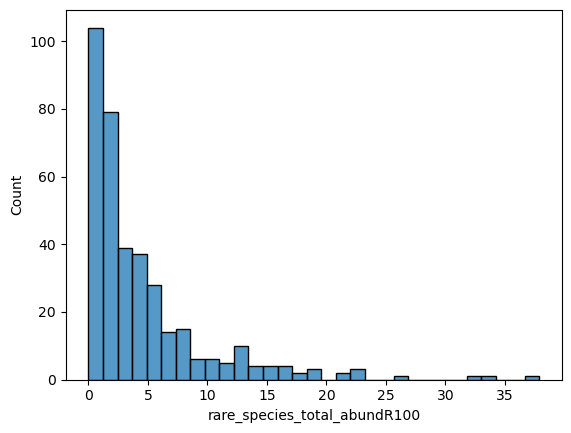

In [18]:
sns.histplot(trimmed_metadata["rare_species_total_abundR100"])

In [19]:
trimmed_raw_transcriptome.loc[:, trimmed_raw_transcriptome.sum() < 200_00]

,AT1G01010,AT1G03987,AT1G01030,AT1G03993,AT1G01046,AT1G03997,AT1G01070,AT1G04003,AT1G01110,AT1G01150,...,ArthCt114,ArthCt124,ArthCt112,ArthCp088,ArthCp086,ArthCt118,ArthCp083,ArthCt111,ArthCp084,ArthCp085
A2450525897_n01_LICRNA01_H06,0,0,34,0,0,0,10,0,7,0,...,10,5,1,29,0,0,30,0,0,6
A2450525897_n01_LICRNA01_F06,12,0,55,0,0,0,28,0,19,2,...,0,3,5,18,0,0,3,0,0,12
A2450525897_n01_LICRNA01_E01,19,0,22,0,0,0,3,0,5,0,...,0,0,0,0,0,0,3,0,0,5
A2450525897_n01_LICRNA01_H10,6,0,5,0,0,0,13,0,1,2,...,2,0,0,2,0,0,8,0,0,0
A2450525897_n01_LICRNA01_F10,6,0,6,0,0,0,12,0,2,1,...,6,0,0,9,0,0,4,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B2449500127_n01_LICRNA04_E07,6,0,7,0,0,0,1,0,7,8,...,21,0,0,14,0,0,1,0,0,3
B2449500127_n01_LICRNA04_F10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,3,0,0,0,0,0,0
B2449500127_n01_LICRNA04_C01,0,0,15,0,0,0,7,0,0,0,...,0,0,0,5,0,0,1,0,0,20
B2449500127_n01_LICRNA04_D12,15,0,11,0,0,0,15,0,10,0,...,16,1,0,4,0,0,33,0,0,25


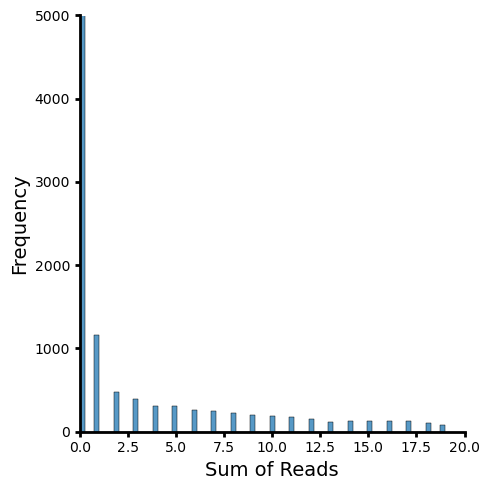

In [20]:
fig, ax = plt.subplots(figsize=(5, 5))
fig.patch.set_facecolor("white")
ax = sns.histplot(
    trimmed_raw_transcriptome.loc[:, trimmed_raw_transcriptome.sum() < 20].sum()
)
plt.xlabel("Sum of Reads", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
sns.despine()
# ax.grid(False)
# plt.axhline(1, color = 'red', linestyle = 'dashed')
ax.spines["bottom"].set_color("black")
ax.spines["bottom"].set_linewidth(2)
ax.spines["left"].set_color("black")
ax.spines["left"].set_linewidth(2)
ax.tick_params(axis="both", width=2)
plt.xlim((0, 20))
plt.ylim((0, 5000))
# handles, labels  =  ax.get_legend_handles_labels()
# ax.legend(loc="upper right")
# plt.title("Current Threshold is 31", fontsize = 20)
plt.xticks(
    fontsize=10,
)  # rotation=90
plt.yticks(fontsize=10)
# plt.ylim(-.02,1)
plt.tight_layout()
# ax.plot([0,1],[0,1], transform=ax.transAxes, linestyle = 'dashed', color = 'k', linewidth = 1.5)
# for line in range(0,full_meta_data.shape[0]):
#      ax.text(pca[:,0][line]+0.01, pca[:,1][line],
#      full_meta_data['plate.pos'][line], horizontalalignment='left',
#      size='medium', color='black', weight='semibold')

In [21]:
trimmed_metadata.loc[
    trimmed_metadata["rare_species_total_abundR100"] > rare_species_abundance_threshold
]

,plate.pos,sampID,sample.type,timepoint,date,time,extractplate,rnaprepplate,Unmapped,No Feature,plate_row,plate_col,Total Reads,Experiment Type,Sample Month,daysincestart,Date and Time,has_rare_species,lacking_core_species,rare_species_total_abundR100
filename,,,,,,,,,,,,,,,,,,,,
A2449446903_n01_LICRNA02_A01,A01,LIC157,plant,t14,1/23/24,8:00,LIC_02,LICRNA_02,758284.0,82176.0,A,1,1246970.0,Long Term,January,83,2024-01-23 08:00:00,True,False,13.5
A2449446903_n01_LICRNA02_B02,B02,LIC170,plant,t15,1/27/24,8:00,LIC_02,LICRNA_02,1839268.0,243038.0,B,2,2982080.0,Long Term,January,87,2024-01-27 08:00:00,True,False,9.0
A2449446903_n01_LICRNA02_C07,C07,LIC243,plant,t21,2/20/24,8:00,LIC_03,LICRNA_02,5931387.0,372994.0,C,7,5220104.0,Long Term,February,111,2024-02-20 08:00:00,True,False,11.5
A2449446903_n01_LICRNA02_C12,C12,LIC315,plant,t27,3/12/24,8:00,LIC_04,LICRNA_02,10581103.0,770403.0,C,12,8128106.0,Long Term,March,132,2024-03-12 08:00:00,True,False,7.0
A2449446903_n01_LICRNA02_D07,D07,LIC244,plant,t21,2/20/24,8:00,LIC_03,LICRNA_02,5559066.0,408088.0,D,7,4167468.0,Long Term,February,111,2024-02-20 08:00:00,True,False,8.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B250508004_n01_LICRNA03_F03,F03,LIC354,plant,t16,1/30/24,8:00,LIC_04,LICRNA_03,6334749.0,510584.0,F,3,8399773.0,Long Term,January,90,2024-01-30 08:00:00,True,True,7.0
B250508004_n01_LICRNA03_F12,F12,LIC486,plant,c1_t08,2/11/24,0:00,LICCIRC_02,LICRNA_03,1281256.0,107554.0,F,12,1278970.0,Circadian Experiment 1,February,102,2024-02-11 00:00:00,True,False,12.8
B250508004_n01_LICRNA03_G01,G01,LIC331,plant,t28,3/14/24,8:00,LIC_04,LICRNA_03,7669950.0,769306.0,G,1,8957746.0,Long Term,March,134,2024-03-14 08:00:00,True,True,13.3


In [22]:
cleaned_raw_transcriptome = trimmed_raw_transcriptome.loc[
    :, trimmed_raw_transcriptome.sum() > expressed_gene_reads_threshold
]

cleaned_raw_transcriptome

,AT1G01010,AT1G01020,AT1G01030,AT1G01040,AT1G01050,AT1G01060,AT1G01070,AT1G01080,AT1G01090,AT1G01100,...,ArthCp080,ArthCp081,Arthcp087,ArthCr091,ArthCr090,ArthCr089,ArthCr088,ArthCp088,ArthCp083,ArthCp085
A2450525897_n01_LICRNA01_H06,0,48,34,111,343,198,10,181,673,5893,...,70,934,10005,0,5,451,53,29,30,6
A2450525897_n01_LICRNA01_F06,12,87,55,150,331,212,28,256,1024,15009,...,64,792,14093,0,7,866,82,18,3,12
A2450525897_n01_LICRNA01_E01,19,27,22,41,135,89,3,56,299,3131,...,24,395,4594,6,10,542,44,0,3,5
A2450525897_n01_LICRNA01_H10,6,24,5,97,140,75,13,53,373,3347,...,22,319,1723,1,1,549,32,2,8,0
A2450525897_n01_LICRNA01_F10,6,42,6,85,215,69,12,50,368,3535,...,29,397,2477,6,4,261,15,9,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B2449500127_n01_LICRNA04_E07,6,59,7,103,206,53,1,144,529,3073,...,58,911,4851,36,2,360,22,14,1,3
B2449500127_n01_LICRNA04_F10,0,25,0,74,178,73,0,55,252,1357,...,21,497,2300,0,0,590,13,3,0,0
B2449500127_n01_LICRNA04_C01,0,20,15,64,99,4,7,78,210,1061,...,12,586,2356,9,2,463,7,5,1,20
B2449500127_n01_LICRNA04_D12,15,82,11,192,347,116,15,228,1108,6467,...,183,2575,9627,32,2,379,47,4,33,25


In [23]:
cleaned_raw_transcriptome = cleaned_raw_transcriptome.loc[
    :, (cleaned_raw_transcriptome > 1).sum() > number_of_samples_expressed_in_threshold
]

In [24]:
cleaned_raw_transcriptome

,AT1G01010,AT1G01020,AT1G01030,AT1G01040,AT1G01050,AT1G01060,AT1G01070,AT1G01080,AT1G01090,AT1G01100,...,ArthCp080,ArthCp081,Arthcp087,ArthCr091,ArthCr090,ArthCr089,ArthCr088,ArthCp088,ArthCp083,ArthCp085
A2450525897_n01_LICRNA01_H06,0,48,34,111,343,198,10,181,673,5893,...,70,934,10005,0,5,451,53,29,30,6
A2450525897_n01_LICRNA01_F06,12,87,55,150,331,212,28,256,1024,15009,...,64,792,14093,0,7,866,82,18,3,12
A2450525897_n01_LICRNA01_E01,19,27,22,41,135,89,3,56,299,3131,...,24,395,4594,6,10,542,44,0,3,5
A2450525897_n01_LICRNA01_H10,6,24,5,97,140,75,13,53,373,3347,...,22,319,1723,1,1,549,32,2,8,0
A2450525897_n01_LICRNA01_F10,6,42,6,85,215,69,12,50,368,3535,...,29,397,2477,6,4,261,15,9,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B2449500127_n01_LICRNA04_E07,6,59,7,103,206,53,1,144,529,3073,...,58,911,4851,36,2,360,22,14,1,3
B2449500127_n01_LICRNA04_F10,0,25,0,74,178,73,0,55,252,1357,...,21,497,2300,0,0,590,13,3,0,0
B2449500127_n01_LICRNA04_C01,0,20,15,64,99,4,7,78,210,1061,...,12,586,2356,9,2,463,7,5,1,20
B2449500127_n01_LICRNA04_D12,15,82,11,192,347,116,15,228,1108,6467,...,183,2575,9627,32,2,379,47,4,33,25


<Axes: ylabel='Count'>

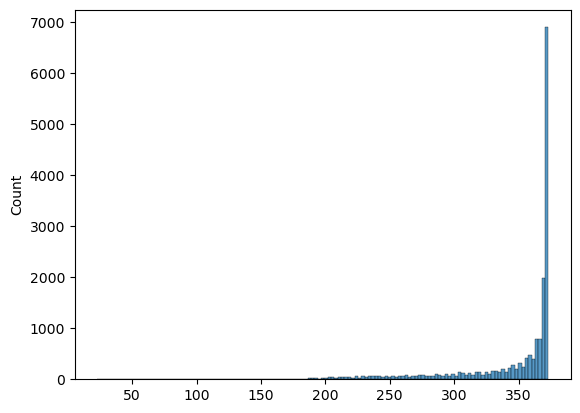

In [25]:
sns.histplot((cleaned_raw_transcriptome > 1).sum())

In [26]:
rare_abund_by_sample

sampID
LIC030    33.6
LIC125    22.3
LIC603    18.5
LIC078    22.4
LIC007    25.9
          ... 
LIC626     0.5
LIC387     0.5
LIC449     0.5
LIC056     0.5
LIC055     1.0
Name: rare_species_total_abundR100, Length: 333, dtype: float64

In [27]:
def calculate_differential_expression_btwn_2_groups(
    list_of_normal_samples: list,
    list_of_perturbed_samples: list,
    raw_transcriptome_data: pd.DataFrame = cleaned_raw_transcriptome,
    og_metadata: pd.DataFrame = trimmed_metadata,
    name_of_perturbation_column: str = "perturbation",
    use_plate_for_design: bool = False,
):

    ##Print out info for diagnosing any issues:

    print(f"Number of normal samples: {len(list_of_normal_samples)}")
    print(f"Number of perturbed samples: {len(list_of_perturbed_samples)}")

    # Subset the transcriptome data
    normal_samples = raw_transcriptome_data.loc[list_of_normal_samples]
    perturbed_samples = raw_transcriptome_data.loc[list_of_perturbed_samples]
    full_transcriptome = pd.concat([normal_samples, perturbed_samples])

    ##generate the metadata object
    normal_meta_data = pd.DataFrame(index=normal_samples.index)
    perturbed_meta_data = pd.DataFrame(index=perturbed_samples.index)
    normal_meta_data[name_of_perturbation_column] = "normal"
    perturbed_meta_data[name_of_perturbation_column] = "perturbed"

    ### Get plate info from the metadata
    normal_meta_data["plate"] = og_metadata.loc[normal_samples.index, "rnaprepplate"]
    perturbed_meta_data["plate"] = og_metadata.loc[
        perturbed_samples.index, "rnaprepplate"
    ]

    # Assemble metadata
    full_metadata = pd.concat([normal_meta_data, perturbed_meta_data])

    inference = pydeseq2.default_inference.DefaultInference(n_cpus=6)
    dds = pydeseq2.dds.DeseqDataSet(
        counts=full_transcriptome,
        metadata=full_metadata,
        design=f"~{name_of_perturbation_column}",
        refit_cooks=True,
        inference=inference,
    )
    if use_plate_for_design:
        dds = pydeseq2.dds.DeseqDataSet(
            counts=full_transcriptome,
            metadata=full_metadata,
            design=f"~{name_of_perturbation_column}+plate",
            refit_cooks=True,
            inference=inference,
        )
    dds.deseq2()
    ds = pydeseq2.ds.DeseqStats(
        dds,
        contrast=[name_of_perturbation_column, "perturbed", "normal"],
        inference=inference,
    )
    ds.summary()
    return ds

In [28]:
list_of_differential_expression_results = []


# Get unique timepoints
timepoints = trimmed_metadata["timepoint"].unique()

for tp in timepoints:
    print(f"\n{'='*50}")
    print(f"Processing timepoint: {tp}")
    print(f"{'='*50}")

    # Get samples for this timepoint
    tp_metadata = trimmed_metadata[trimmed_metadata["timepoint"] == tp]

    # Split into normal (<=5) and perturbed (>5) based on rare species abundance
    normal_samples = tp_metadata[
        tp_metadata["rare_species_total_abundR100"] <= rare_species_abundance_threshold
    ].index.tolist()
    perturbed_samples = tp_metadata[
        tp_metadata["rare_species_total_abundR100"] > rare_species_abundance_threshold
    ].index.tolist()

    # Filter to only include samples present in cleaned_raw_transcriptome
    normal_samples = [s for s in normal_samples if s in cleaned_raw_transcriptome.index]
    perturbed_samples = [
        s for s in perturbed_samples if s in cleaned_raw_transcriptome.index
    ]

    # Skip if either group has too few samples
    if len(normal_samples) < 2 or len(perturbed_samples) < 2:
        print(
            f"Skipping timepoint {tp}: insufficient samples (normal={len(normal_samples)}, perturbed={len(perturbed_samples)})"
        )
        continue

    try:
        ds_result = calculate_differential_expression_btwn_2_groups(
            list_of_normal_samples=normal_samples,
            list_of_perturbed_samples=perturbed_samples,
            raw_transcriptome_data=cleaned_raw_transcriptome,
            og_metadata=trimmed_metadata,
            name_of_perturbation_column="rare_species_greater_5",
            use_plate_for_design=False,
        )
        list_of_differential_expression_results.append(
            {"timepoint": tp, "result": ds_result}
        )
    except Exception as e:
        print(f"Error processing timepoint {tp}: {e}")

print(f"\nCompleted! Total results: {len(list_of_differential_expression_results)}")


Processing timepoint: t14
Number of normal samples: 5
Number of perturbed samples: 2
Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 3.31 seconds.

Fitting dispersion trend curve...
... done in 0.42 seconds.

Fitting MAP dispersions...
... done in 3.64 seconds.

Fitting LFCs...
... done in 2.88 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.95 seconds.

Fitting size factors...
... done in 0.01 seconds.



Log2 fold change & Wald test p-value: rare_species_greater_5 perturbed vs normal
              baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
AT1G01010    23.042526       -0.438901  0.783892 -0.559900  0.575548  0.906801
AT1G01020    84.253266        0.225365  0.436973  0.515742  0.606035  0.915891
AT1G01030    44.017698       -0.068202  0.493065 -0.138322  0.889986  0.980893
AT1G01040   170.361128        0.132467  0.312117  0.424414  0.671264  0.934509
AT1G01050   255.120935       -0.146770  0.305053 -0.481129  0.630425  0.923509
...                ...             ...       ...       ...       ...       ...
ArthCr089  2316.079433       -0.131242  0.447349 -0.293377  0.769234  0.956143
ArthCr088   210.774282        0.364102  0.491273  0.741141  0.458608  0.860778
ArthCp088     9.797099       -0.503911  1.254607 -0.401648  0.687943       NaN
ArthCp083    18.783767       -1.119463  0.836596 -1.338116  0.180859  0.696347
ArthCp085    10.738686        2.215972  0.981429  

Fitting dispersions...
... done in 3.30 seconds.

Fitting dispersion trend curve...
... done in 0.42 seconds.

Fitting MAP dispersions...
... done in 3.73 seconds.

Fitting LFCs...
... done in 2.41 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.93 seconds.

Fitting size factors...
... done in 0.01 seconds.



Log2 fold change & Wald test p-value: rare_species_greater_5 perturbed vs normal
              baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
AT1G01010    11.080991        1.815010  1.143715  1.586943  0.112525  0.998868
AT1G01020    63.765101        0.009388  0.418337  0.022441  0.982096  0.998868
AT1G01030    18.677859        0.364702  0.676238  0.539311  0.589672  0.998868
AT1G01040   149.392352        0.148930  0.261896  0.568661  0.569586  0.998868
AT1G01050   194.570799       -0.258307  0.301717 -0.856123  0.391930  0.998868
...                ...             ...       ...       ...       ...       ...
ArthCr089  2355.193560        0.548500  0.260441  2.106040  0.035201  0.998868
ArthCr088   166.575863        0.659517  0.319527  2.064040  0.039014  0.998868
ArthCp088    15.402725       -0.080626  0.833250 -0.096761  0.922916  0.998868
ArthCp083    37.411412       -0.376246  0.623310 -0.603627  0.546092  0.998868
ArthCp085     7.482260       -1.165388  1.218454 -

Fitting dispersions...
... done in 3.51 seconds.

Fitting dispersion trend curve...
... done in 0.42 seconds.

Fitting MAP dispersions...
... done in 3.53 seconds.

Fitting LFCs...
... done in 2.62 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.98 seconds.

Fitting size factors...
... done in 0.01 seconds.



Log2 fold change & Wald test p-value: rare_species_greater_5 perturbed vs normal
              baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
AT1G01010    14.734969       -0.556409  1.446766 -0.384588  0.700542  0.999991
AT1G01020    48.166910        0.293579  0.614729  0.477574  0.632953  0.999991
AT1G01030    10.790900       -1.207695  1.039226 -1.162110  0.245191  0.999991
AT1G01040   144.750024        0.082728  0.408906  0.202315  0.839671  0.999991
AT1G01050   254.732610        0.452441  0.395704  1.143383  0.252880  0.999991
...                ...             ...       ...       ...       ...       ...
ArthCr089  3583.848026        0.166027  0.385337  0.430861  0.666569  0.999991
ArthCr088   269.523568       -0.076732  0.352802 -0.217494  0.827823  0.999991
ArthCp088     8.504604        0.233773  1.177554  0.198524  0.842635  0.999991
ArthCp083    49.194937        0.157983  0.527765  0.299343  0.764679  0.999991
ArthCp085    11.383310        0.545875  1.153965  

Fitting dispersions...
... done in 3.27 seconds.

Fitting dispersion trend curve...
... done in 0.44 seconds.

Fitting MAP dispersions...
... done in 3.55 seconds.

Fitting LFCs...
... done in 2.36 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.97 seconds.

Fitting size factors...
... done in 0.01 seconds.



Log2 fold change & Wald test p-value: rare_species_greater_5 perturbed vs normal
              baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
AT1G01010    22.701126       -1.149790  0.685947 -1.676209  0.093697  0.999936
AT1G01020    78.400483       -0.321935  0.474305 -0.678751  0.497295  0.999936
AT1G01030    25.868840       -0.296070  0.708009 -0.418173  0.675820  0.999936
AT1G01040   206.690808       -0.254629  0.292291 -0.871148  0.383673  0.999936
AT1G01050   368.018417        0.062710  0.292357  0.214498  0.830159  0.999936
...                ...             ...       ...       ...       ...       ...
ArthCr089  3462.477424       -0.848056  0.342807 -2.473858  0.013366  0.999936
ArthCr088   353.771856       -0.778216  0.383437 -2.029579  0.042399  0.999936
ArthCp088    12.499028       -0.231173  0.849215 -0.272220  0.785453  0.999936
ArthCp083    56.446051       -0.861654  0.478505 -1.800721  0.071747  0.999936
ArthCp085    12.084169        0.568269  1.038807  

Fitting dispersions...
... done in 3.27 seconds.

Fitting dispersion trend curve...
... done in 0.44 seconds.

Fitting MAP dispersions...
... done in 3.45 seconds.

Fitting LFCs...
... done in 2.62 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 1.04 seconds.

Fitting size factors...
... done in 0.00 seconds.



Log2 fold change & Wald test p-value: rare_species_greater_5 perturbed vs normal
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
AT1G01010   16.732559        0.144779  0.864966  0.167381  0.867070  0.999734
AT1G01020   20.742664        0.658963  0.954868  0.690109  0.490126  0.996330
AT1G01030   12.787656        0.038921  1.205511  0.032286  0.974244  0.999734
AT1G01040   64.732276        0.494419  0.583417  0.847454  0.396742  0.989591
AT1G01050  143.779824        0.167261  0.345012  0.484799  0.627819  0.996330
...               ...             ...       ...       ...       ...       ...
ArthCr089  811.218826        0.538275  0.329625  1.632991  0.102471  0.972765
ArthCr088   74.673964        0.972477  0.620151  1.568130  0.116851  0.972765
ArthCp088    0.187393        0.290871  4.544790  0.064001  0.948969  0.999734
ArthCp083    4.532873        1.718074  1.771467  0.969859  0.332117  0.989591
ArthCp085    2.133608       -0.396790  2.184929 -0.181603  0.

Fitting dispersions...
... done in 3.55 seconds.

Fitting dispersion trend curve...
... done in 0.44 seconds.

Fitting MAP dispersions...
... done in 3.52 seconds.

Fitting LFCs...
... done in 2.77 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.95 seconds.

Fitting size factors...
... done in 0.00 seconds.



Log2 fold change & Wald test p-value: rare_species_greater_5 perturbed vs normal
              baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
AT1G01010     5.828940        1.259751  2.666378  0.472458  0.636600       NaN
AT1G01020    41.755678        0.195693  0.874354  0.223815  0.822901  0.983773
AT1G01030    27.669855       -0.399910  1.145150 -0.349220  0.726924       NaN
AT1G01040   101.171370       -0.161655  0.633214 -0.255293  0.798497  0.980585
AT1G01050   112.721100        0.494518  0.635182  0.778545  0.436248  0.926175
...                ...             ...       ...       ...       ...       ...
ArthCr089  1269.615638        0.088598  0.559733  0.158286  0.874232  0.985954
ArthCr088   107.427765        0.785661  0.887943  0.884811  0.376259  0.907967
ArthCp088     0.102665       -0.446844  4.581138 -0.097540  0.922298       NaN
ArthCp083     7.631815       -0.668419  2.497711 -0.267613  0.788998       NaN
ArthCp085     4.798149        0.427054  2.196727  

Fitting dispersions...
... done in 3.59 seconds.

Fitting dispersion trend curve...
... done in 0.50 seconds.

Fitting MAP dispersions...
... done in 3.97 seconds.

Fitting LFCs...
... done in 2.49 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.95 seconds.

Fitting size factors...
... done in 0.01 seconds.



Log2 fold change & Wald test p-value: rare_species_greater_5 perturbed vs normal
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
AT1G01010   12.673318       -2.193585  1.227035 -1.787712  0.073823  0.999826
AT1G01020   51.535167        0.398766  0.558594  0.713875  0.475304  0.999826
AT1G01030   33.619525        0.337937  0.568506  0.594431  0.552224  0.999826
AT1G01040  111.160668       -0.393967  0.398107 -0.989600  0.322370  0.999826
AT1G01050  229.082971        0.070597  0.297352  0.237420  0.812331  0.999826
...               ...             ...       ...       ...       ...       ...
ArthCr089  623.470960        0.089571  0.267282  0.335116  0.737537  0.999826
ArthCr088   41.439495        0.368392  0.639607  0.575967  0.564638  0.999826
ArthCp088    4.623443        0.027485  1.982870  0.013861  0.988941  0.999826
ArthCp083    6.067498        1.061115  1.641200  0.646548  0.517924  0.999826
ArthCp085    3.441357       -0.652307  1.920804 -0.339601  0.

Fitting dispersions...
... done in 3.28 seconds.

Fitting dispersion trend curve...
... done in 0.46 seconds.

Fitting MAP dispersions...
... done in 3.42 seconds.

Fitting LFCs...
... done in 2.48 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.98 seconds.

Fitting size factors...
... done in 0.01 seconds.



Log2 fold change & Wald test p-value: rare_species_greater_5 perturbed vs normal
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
AT1G01010    6.932322       -0.802089  0.940649 -0.852698  0.393827  0.998538
AT1G01020   23.651654       -0.628872  0.565666 -1.111737  0.266251  0.998538
AT1G01030   14.073083        0.159133  0.626822  0.253873  0.799594  0.998538
AT1G01040   52.306085       -0.118103  0.421158 -0.280424  0.779153  0.998538
AT1G01050  119.268157       -0.133876  0.347603 -0.385142  0.700133  0.998538
...               ...             ...       ...       ...       ...       ...
ArthCr089  352.901763        0.508934  0.344646  1.476685  0.139760  0.998538
ArthCr088   39.357860        0.471790  0.546412  0.863433  0.387900  0.998538
ArthCp088    1.352288        1.245881  1.942264  0.641458  0.521225  0.998538
ArthCp083    3.105030        0.649018  1.475486  0.439868  0.660033  0.998538
ArthCp085    4.022016        1.874606  1.432230  1.308872  0.

Fitting dispersions...
... done in 3.21 seconds.

Fitting dispersion trend curve...
... done in 0.44 seconds.

Fitting MAP dispersions...
... done in 3.56 seconds.

Fitting LFCs...
... done in 2.28 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.96 seconds.

Fitting size factors...
... done in 0.00 seconds.



Log2 fold change & Wald test p-value: rare_species_greater_5 perturbed vs normal
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
AT1G01010    9.075198       -0.069277  0.866482 -0.079952  0.936276  0.998965
AT1G01020   49.354920        0.012714  0.477526  0.026626  0.978758  0.998965
AT1G01030   17.667445       -0.217179  0.565901 -0.383776  0.701144  0.998965
AT1G01040  117.384550        0.025057  0.339129  0.073887  0.941101  0.998965
AT1G01050  287.272888        0.166384  0.235625  0.706137  0.480103  0.998965
...               ...             ...       ...       ...       ...       ...
ArthCr089  562.888905       -0.000126  0.405815 -0.000312  0.999751  0.999948
ArthCr088   55.967579       -0.201847  0.426828 -0.472901  0.636284  0.998965
ArthCp088    8.208301       -1.549820  1.019692 -1.519890  0.128539  0.998965
ArthCp083   12.867363        0.043666  0.810250  0.053893  0.957021  0.998965
ArthCp085    9.425587       -0.307243  0.773147 -0.397393  0.

Fitting dispersions...
... done in 3.27 seconds.

Fitting dispersion trend curve...
... done in 0.45 seconds.

Fitting MAP dispersions...
... done in 3.43 seconds.

Fitting LFCs...
... done in 2.34 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.94 seconds.

Fitting size factors...
... done in 0.00 seconds.



Log2 fold change & Wald test p-value: rare_species_greater_5 perturbed vs normal
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
AT1G01010   17.131550       -1.638760  0.781312 -2.097446  0.035954       NaN
AT1G01020   42.763589        0.258651  0.527911  0.489953  0.624167  0.973041
AT1G01030    9.323262        0.136428  0.861678  0.158328  0.874198       NaN
AT1G01040   80.984725        1.030227  0.376956  2.733018  0.006276  0.304084
AT1G01050  205.670125        0.182673  0.286670  0.637225  0.523978  0.950352
...               ...             ...       ...       ...       ...       ...
ArthCr089  723.254919       -0.439716  0.461039 -0.953750  0.340210  0.899083
ArthCr088   48.604026       -0.287700  0.569237 -0.505414  0.613268  0.972305
ArthCp088    6.236000        2.128524  1.521665  1.398813  0.161869       NaN
ArthCp083    6.901236        0.629817  1.169768  0.538412  0.590292       NaN
ArthCp085    7.028430        0.164456  1.307245  0.125804  0.

Fitting dispersions...
... done in 3.49 seconds.

Fitting dispersion trend curve...
... done in 0.47 seconds.

Fitting MAP dispersions...
... done in 3.52 seconds.

Fitting LFCs...
... done in 2.33 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 1.01 seconds.

Fitting size factors...
... done in 0.00 seconds.



Log2 fold change & Wald test p-value: rare_species_greater_5 perturbed vs normal
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
AT1G01010   10.573842        0.903503  0.828066  1.091100  0.275229       NaN
AT1G01020   45.383900       -0.306708  0.432196 -0.709651  0.477921  0.999167
AT1G01030   18.919309       -0.026417  0.617688 -0.042768  0.965887  0.999167
AT1G01040  104.869243        0.109121  0.412837  0.264320  0.791533  0.999167
AT1G01050  240.106429        0.040425  0.301612  0.134030  0.893379  0.999167
...               ...             ...       ...       ...       ...       ...
ArthCr089  223.172557       -0.772469  0.475441 -1.624743  0.104217  0.999167
ArthCr088   26.706730       -0.870310  0.574952 -1.513709  0.130100  0.999167
ArthCp088    9.188339       -0.901103  0.907173 -0.993309  0.320559       NaN
ArthCp083    8.470385       -0.731932  0.929137 -0.787755  0.430840       NaN
ArthCp085    7.445681       -0.114704  0.934077 -0.122799  0.

Fitting dispersions...
... done in 3.31 seconds.

Fitting dispersion trend curve...
... done in 0.42 seconds.

Fitting MAP dispersions...
... done in 3.58 seconds.

Fitting LFCs...
... done in 2.25 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.97 seconds.

Fitting size factors...
... done in 0.00 seconds.



Log2 fold change & Wald test p-value: rare_species_greater_5 perturbed vs normal
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
AT1G01010    8.327423        0.629310  1.120493  0.561636  0.574364  0.998874
AT1G01020   57.483968        0.261749  0.370510  0.706458  0.479903  0.998874
AT1G01030   33.288089        1.127381  0.513225  2.196662  0.028045  0.998874
AT1G01040   94.194888        0.065185  0.318144  0.204893  0.837656  0.998874
AT1G01050  249.921278        0.213253  0.295621  0.721372  0.470681  0.998874
...               ...             ...       ...       ...       ...       ...
ArthCr089  506.040298        0.152887  0.315864  0.484028  0.628366  0.998874
ArthCr088   51.157487       -0.024741  0.419530 -0.058974  0.952973  0.998874
ArthCp088   10.959722        0.453296  0.898380  0.504570  0.613861  0.998874
ArthCp083   14.438688       -0.376090  1.022617 -0.367773  0.713043  0.998874
ArthCp085    8.047360       -0.837036  0.861227 -0.971910  0.

Fitting dispersions...
... done in 3.59 seconds.

Fitting dispersion trend curve...
... done in 0.45 seconds.

Fitting MAP dispersions...
... done in 3.42 seconds.

Fitting LFCs...
... done in 2.27 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.96 seconds.

Fitting size factors...
... done in 0.01 seconds.



Log2 fold change & Wald test p-value: rare_species_greater_5 perturbed vs normal
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
AT1G01010    9.360369        0.679901  1.074170  0.632955  0.526763       NaN
AT1G01020   67.102513       -0.151185  0.362234 -0.417367  0.676410  0.999694
AT1G01030   22.755263       -0.621428  0.551410 -1.126981  0.259751  0.999694
AT1G01040  111.470100        0.189984  0.353041  0.538136  0.590483  0.999694
AT1G01050  290.369334       -0.067788  0.307730 -0.220285  0.825649  0.999694
...               ...             ...       ...       ...       ...       ...
ArthCr089  674.780966       -0.554155  0.313819 -1.765841  0.077423  0.999694
ArthCr088   61.928726        0.005096  0.429269  0.011872  0.990528  0.999694
ArthCp088    9.035784        0.236899  0.815283  0.290572  0.771378       NaN
ArthCp083   14.608172        0.042033  0.746118  0.056336  0.955074  0.999694
ArthCp085   10.522192       -0.307905  0.767531 -0.401163  0.

Fitting dispersions...
... done in 3.44 seconds.

Fitting dispersion trend curve...
... done in 0.48 seconds.

Fitting MAP dispersions...
... done in 3.86 seconds.

Fitting LFCs...
... done in 2.69 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 73 outlier genes.

Fitting dispersions...
... done in 0.03 seconds.

Fitting MAP dispersions...
... done in 0.03 seconds.

Fitting LFCs...
... done in 0.05 seconds.

Running Wald tests...
... done in 1.00 seconds.

Fitting size factors...
... done in 0.00 seconds.



Log2 fold change & Wald test p-value: rare_species_greater_5 perturbed vs normal
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
AT1G01010    5.462072       -0.871802  1.244159 -0.700716  0.483480       NaN
AT1G01020   53.215496        0.046077  0.370893  0.124234  0.901130  0.983892
AT1G01030   14.328351       -2.213171  0.728341 -3.038649  0.002376  0.151302
AT1G01040  111.308722        0.045876  0.288281  0.159136  0.873562  0.980523
AT1G01050  222.646625        0.025464  0.217214  0.117231  0.906677  0.985269
...               ...             ...       ...       ...       ...       ...
ArthCr089  808.504968        0.704372  0.572716  1.229879  0.218742  0.784157
ArthCr088   29.639512        0.259014  0.422450  0.613124  0.539795  0.907850
ArthCp088   10.022036       -0.289541  0.892605 -0.324377  0.745653       NaN
ArthCp083   16.646939        0.128222  0.683192  0.187681  0.851127  0.976541
ArthCp085   17.456079       -0.932648  0.813521 -1.146435  0.

Fitting dispersions...
... done in 3.34 seconds.

Fitting dispersion trend curve...
... done in 0.46 seconds.

Fitting MAP dispersions...
... done in 3.49 seconds.

Fitting LFCs...
... done in 2.65 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.97 seconds.

Fitting size factors...
... done in 0.00 seconds.



Log2 fold change & Wald test p-value: rare_species_greater_5 perturbed vs normal
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
AT1G01010   17.137315        0.108087  1.283542  0.084210  0.932890  0.998001
AT1G01020   59.802847        0.452086  0.865967  0.522059  0.601629  0.996350
AT1G01030   13.732965        1.761999  1.221169  1.442879  0.149055  0.964830
AT1G01040  131.260076        0.295253  0.495166  0.596270  0.550995  0.996350
AT1G01050  280.135775        0.107018  0.324086  0.330214  0.741238  0.996350
...               ...             ...       ...       ...       ...       ...
ArthCr089  625.415151       -0.010304  0.264244 -0.038996  0.968894  0.999523
ArthCr088   48.420611       -0.189673  0.681469 -0.278329  0.780760  0.996350
ArthCp088    4.190219       -2.301021  2.267348 -1.014852  0.310177  0.996350
ArthCp083   14.071409        0.922632  1.482461  0.622365  0.533702  0.996350
ArthCp085   10.497329        0.286316  1.405752  0.203675  0.

Fitting dispersions...
... done in 3.29 seconds.

Fitting dispersion trend curve...
... done in 0.46 seconds.

Fitting MAP dispersions...
... done in 3.43 seconds.

Fitting LFCs...
... done in 2.58 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.98 seconds.

Fitting size factors...
... done in 0.01 seconds.



Log2 fold change & Wald test p-value: rare_species_greater_5 perturbed vs normal
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
AT1G01010    5.043403       -5.300503  2.541733 -2.085389  0.037034       NaN
AT1G01020   50.136346        0.168356  0.501489  0.335713  0.737088       NaN
AT1G01030   21.925333       -0.175491  0.929139 -0.188875  0.850191       NaN
AT1G01040  149.302430       -0.006924  0.535489 -0.012930  0.989683  0.998195
AT1G01050  189.922085        0.299026  0.351935  0.849662  0.395513  0.763234
...               ...             ...       ...       ...       ...       ...
ArthCr089  389.520596       -0.253676  0.419211 -0.605126  0.545095  0.843528
ArthCr088   14.661313        0.029614  0.809996  0.036561  0.970835       NaN
ArthCp088    3.343409        2.078143  2.549914  0.814986  0.415081       NaN
ArthCp083   13.098330        0.058721  1.131660  0.051889  0.958617       NaN
ArthCp085   20.559756       -0.124393  0.738641 -0.168408  0.

Fitting dispersions...
... done in 3.44 seconds.

Fitting dispersion trend curve...
... done in 0.43 seconds.

Fitting MAP dispersions...
... done in 3.42 seconds.

Fitting LFCs...
... done in 2.87 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 1.04 seconds.

Fitting size factors...
... done in 0.00 seconds.



Log2 fold change & Wald test p-value: rare_species_greater_5 perturbed vs normal
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
AT1G01010    3.586636       -2.910709  2.263665 -1.285839  0.198499  0.999573
AT1G01020   42.399036       -0.231824  0.682162 -0.339838  0.733979  0.999573
AT1G01030   22.503768        1.081662  0.842342  1.284112  0.199103  0.999573
AT1G01040   85.020311       -0.845684  0.590135 -1.433035  0.151848  0.999573
AT1G01050  212.001365       -0.205143  0.413295 -0.496360  0.619640  0.999573
...               ...             ...       ...       ...       ...       ...
ArthCr089  346.683127        0.566411  0.387945  1.460031  0.144282  0.999573
ArthCr088   23.799195        0.494250  0.972373  0.508292  0.611248  0.999573
ArthCp088    8.848439       -0.588265  1.375068 -0.427808  0.668791  0.999573
ArthCp083    8.653670        0.252605  1.672612  0.151024  0.879956  0.999573
ArthCp085    7.149250       -1.018922  1.652322 -0.616661  0.

Fitting dispersions...
... done in 3.33 seconds.

Fitting dispersion trend curve...
... done in 0.48 seconds.

Fitting MAP dispersions...
... done in 3.54 seconds.

Fitting LFCs...
... done in 2.47 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.98 seconds.

Fitting size factors...
... done in 0.00 seconds.



Log2 fold change & Wald test p-value: rare_species_greater_5 perturbed vs normal
              baseMean  log2FoldChange     lfcSE      stat    pvalue     padj
AT1G01010     6.340787        1.133709  1.428117  0.793849  0.427283  0.99993
AT1G01020    51.564805        0.845124  0.489194  1.727584  0.084063  0.99993
AT1G01030    20.237407        0.609256  0.806532  0.755403  0.450007  0.99993
AT1G01040   126.621703        0.355287  0.359201  0.989106  0.322612  0.99993
AT1G01050   359.624581        0.631476  0.271266  2.327887  0.019918  0.99993
...                ...             ...       ...       ...       ...      ...
ArthCr089  1811.955207        0.328602  0.672666  0.488507  0.625190  0.99993
ArthCr088    78.999450        0.675054  0.438975  1.537796  0.124099  0.99993
ArthCp088    16.299308        0.035769  0.840878  0.042537  0.966070  0.99993
ArthCp083    24.429109       -0.199099  0.758671 -0.262431  0.792989  0.99993
ArthCp085    20.051421        0.091396  0.854808  0.106920  0

Fitting dispersions...
... done in 3.38 seconds.

Fitting dispersion trend curve...
... done in 0.44 seconds.

Fitting MAP dispersions...
... done in 3.56 seconds.

Fitting LFCs...
... done in 2.48 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...


Log2 fold change & Wald test p-value: rare_species_greater_5 perturbed vs normal
              baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
AT1G01010     4.831789       -1.323158  1.724141 -0.767430  0.442826  0.999599
AT1G01020    37.396573       -0.538198  0.863539 -0.623247  0.533122  0.999599
AT1G01030     5.417486       -1.949862  1.727815 -1.128513  0.259103  0.999599
AT1G01040   103.969284       -0.292908  0.433339 -0.675933  0.499083  0.999599
AT1G01050   224.359910        0.240858  0.400848  0.600870  0.547926  0.999599
...                ...             ...       ...       ...       ...       ...
ArthCr089  1026.867062       -0.967052  0.831006 -1.163713  0.244541  0.999599
ArthCr088    42.833990        0.401681  0.717900  0.559522  0.575806  0.999599
ArthCp088     7.695965       -0.649868  1.643325 -0.395459  0.692504  0.999599
ArthCp083    19.478713        0.002324  0.980631  0.002370  0.998109  0.999599
ArthCp085    11.272994        1.857692  1.346784  

... done in 0.95 seconds.



In [29]:
tp_metadata

,plate.pos,sampID,sample.type,timepoint,date,time,extractplate,rnaprepplate,Unmapped,No Feature,plate_row,plate_col,Total Reads,Experiment Type,Sample Month,daysincestart,Date and Time,has_rare_species,lacking_core_species,rare_species_total_abundR100
filename,,,,,,,,,,,,,,,,,,,,
B250508004_n01_LICRNA03_A11,A11,LIC457,plant,c1_t07,2/10/24,20:00,LICCIRC_01,LICRNA_03,2674528.0,376117.0,A,11,7080205.0,Circadian Experiment 1,February,101,2024-02-10 20:00:00,True,False,1.7
B250508004_n01_LICRNA03_B11,B11,LIC458,plant,c1_t07,2/10/24,20:00,LICCIRC_01,LICRNA_03,2708899.0,279807.0,B,11,5975492.0,Circadian Experiment 1,February,101,2024-02-10 20:00:00,True,True,5.9
B250508004_n01_LICRNA03_C11,C11,LIC459,plant,c1_t07,2/10/24,20:00,LICCIRC_01,LICRNA_03,9536959.0,1915565.0,C,11,22087076.0,Circadian Experiment 1,February,101,2024-02-10 20:00:00,False,False,0.0
B250508004_n01_LICRNA03_D11,D11,LIC460,plant,c1_t07,2/10/24,20:00,LICCIRC_01,LICRNA_03,4996759.0,1265822.0,D,11,14457644.0,Circadian Experiment 1,February,101,2024-02-10 20:00:00,True,False,4.0
B250508004_n01_LICRNA03_E11,E11,LIC461,plant,c1_t07,2/10/24,20:00,LICCIRC_01,LICRNA_03,874618.0,149646.0,E,11,2408154.0,Circadian Experiment 1,February,101,2024-02-10 20:00:00,True,True,0.5
B250508004_n01_LICRNA03_F11,F11,LIC462,plant,c1_t07,2/10/24,20:00,LICCIRC_01,LICRNA_03,1218515.0,110644.0,F,11,2197530.0,Circadian Experiment 1,February,101,2024-02-10 20:00:00,True,True,2.3
B250508004_n01_LICRNA03_G11,G11,LIC463,plant,c1_t07,2/10/24,20:00,LICCIRC_01,LICRNA_03,2261397.0,492243.0,G,11,6315886.0,Circadian Experiment 1,February,101,2024-02-10 20:00:00,True,True,4.0
B250508004_n01_LICRNA03_H11,H11,LIC464,plant,c1_t07,2/10/24,20:00,LICCIRC_01,LICRNA_03,326959.0,60346.0,H,11,1509679.0,Circadian Experiment 1,February,101,2024-02-10 20:00:00,True,True,2.9


In [30]:
list_of_differential_expression_results

[{'timepoint': 't14', 'result': <pydeseq2.ds.DeseqStats at 0x18bcc7a10>},
 {'timepoint': 't15', 'result': <pydeseq2.ds.DeseqStats at 0x1981ce210>},
 {'timepoint': 't21', 'result': <pydeseq2.ds.DeseqStats at 0x1981cf4d0>},
 {'timepoint': 't27', 'result': <pydeseq2.ds.DeseqStats at 0x197282520>},
 {'timepoint': 't01', 'result': <pydeseq2.ds.DeseqStats at 0x197282780>},
 {'timepoint': 't02', 'result': <pydeseq2.ds.DeseqStats at 0x1972d5490>},
 {'timepoint': 't03', 'result': <pydeseq2.ds.DeseqStats at 0x193cb7bd0>},
 {'timepoint': 't05', 'result': <pydeseq2.ds.DeseqStats at 0x1972f4270>},
 {'timepoint': 't07', 'result': <pydeseq2.ds.DeseqStats at 0x1972f0650>},
 {'timepoint': 't12', 'result': <pydeseq2.ds.DeseqStats at 0x1972f0d50>},
 {'timepoint': 't13', 'result': <pydeseq2.ds.DeseqStats at 0x1972f1050>},
 {'timepoint': 't06', 'result': <pydeseq2.ds.DeseqStats at 0x1972f1250>},
 {'timepoint': 't09', 'result': <pydeseq2.ds.DeseqStats at 0x1972f1450>},
 {'timepoint': 'c1_t08', 'result': <py

In [31]:
import random

list_of_random_differential_expression_results = []

# Get only timepoints that had sufficient samples in the previous analysis
timepoints = [result["timepoint"] for result in list_of_differential_expression_results]

# Set seed for reproducibility
random.seed(11106)

for tp in timepoints:
    print(f"\n{'='*50}")
    print(f"Processing timepoint: {tp} (random split)")
    print(f"{'='*50}")

    # Get samples for this timepoint
    tp_metadata = trimmed_metadata[trimmed_metadata["timepoint"] == tp]

    # Get all samples present in cleaned_raw_transcriptome
    all_samples = [
        s for s in tp_metadata.index.tolist() if s in cleaned_raw_transcriptome.index
    ]

    # Skip if too few samples
    if len(all_samples) < 4:
        print(f"Skipping timepoint {tp}: insufficient samples ({len(all_samples)})")
        continue

    # Randomly shuffle and split into two groups
    random.shuffle(all_samples)
    midpoint = len(all_samples) // 2
    group1_samples = all_samples[:midpoint]
    group2_samples = all_samples[midpoint:]

    print(
        f"Group 1: {len(group1_samples)} samples, Group 2: {len(group2_samples)} samples"
    )

    try:
        ds_result = calculate_differential_expression_btwn_2_groups(
            list_of_normal_samples=group1_samples,
            list_of_perturbed_samples=group2_samples,
            raw_transcriptome_data=cleaned_raw_transcriptome,
            og_metadata=trimmed_metadata,
            name_of_perturbation_column="random_split",
            use_plate_for_design=False,
        )
        list_of_random_differential_expression_results.append(
            {"timepoint": tp, "result": ds_result}
        )
    except Exception as e:
        print(f"Error processing timepoint {tp}: {e}")

print(
    f"\nCompleted! Total results: {len(list_of_random_differential_expression_results)}"
)

Fitting size factors...
... done in 0.00 seconds.




Processing timepoint: t14 (random split)
Group 1: 3 samples, Group 2: 4 samples
Number of normal samples: 3
Number of perturbed samples: 4
Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 3.41 seconds.

Fitting dispersion trend curve...
... done in 0.45 seconds.

Fitting MAP dispersions...
... done in 3.50 seconds.

Fitting LFCs...
... done in 2.57 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 1.00 seconds.

Fitting size factors...
... done in 0.01 seconds.



Log2 fold change & Wald test p-value: random_split perturbed vs normal
              baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
AT1G01010    23.042526        0.162051  0.701418  0.231033  0.817289  0.999581
AT1G01020    84.253266       -0.373938  0.385710 -0.969479  0.332306  0.999581
AT1G01030    44.017698        0.095325  0.438248  0.217514  0.827808  0.999581
AT1G01040   170.361128       -0.037911  0.289040 -0.131161  0.895648  0.999581
AT1G01050   255.120935        0.125416  0.281603  0.445365  0.656056  0.999581
...                ...             ...       ...       ...       ...       ...
ArthCr089  2316.079433        0.078219  0.426205  0.183524  0.854387  0.999581
ArthCr088   210.774282       -0.273548  0.463582 -0.590074  0.555141  0.999581
ArthCp088     9.797099       -1.078325  1.055991 -1.021149  0.307184  0.999581
ArthCp083    18.783767        0.447837  0.748754  0.598109  0.549767  0.999581
ArthCp085    10.738686       -2.192592  0.925471 -2.369165  

Fitting dispersions...
... done in 3.20 seconds.

Fitting dispersion trend curve...
... done in 0.47 seconds.

Fitting MAP dispersions...
... done in 3.48 seconds.

Fitting LFCs...
... done in 2.40 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.93 seconds.

Fitting size factors...
... done in 0.01 seconds.



Log2 fold change & Wald test p-value: random_split perturbed vs normal
              baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
AT1G01010    11.080991        0.555187  1.090324  0.509194  0.610616  0.999729
AT1G01020    63.765101        0.633406  0.322200  1.965879  0.049313  0.999729
AT1G01030    18.677859       -0.181133  0.593108 -0.305396  0.760065  0.999729
AT1G01040   149.392352        0.120520  0.226846  0.531283  0.595223  0.999729
AT1G01050   194.570799        0.003157  0.267135  0.011819  0.990570  0.999729
...                ...             ...       ...       ...       ...       ...
ArthCr089  2355.193560        0.330655  0.244097  1.354601  0.175545  0.999729
ArthCr088   166.575863        0.499448  0.291469  1.713553  0.086611  0.999729
ArthCp088    15.402725        1.032431  0.677678  1.523484  0.127638  0.999729
ArthCp083    37.411412        0.330951  0.536595  0.616763  0.537391  0.999729
ArthCp085     7.482260        0.358379  1.029981  0.347948  

Fitting dispersions...
... done in 3.25 seconds.

Fitting dispersion trend curve...
... done in 0.47 seconds.

Fitting MAP dispersions...
... done in 3.65 seconds.

Fitting LFCs...
... done in 2.49 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.93 seconds.

Fitting size factors...
... done in 0.01 seconds.



Log2 fold change & Wald test p-value: random_split perturbed vs normal
              baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
AT1G01010    14.734969        2.208043  1.123597  1.965155  0.049396  0.792238
AT1G01020    48.166910       -0.477646  0.521391 -0.916098  0.359615  0.966033
AT1G01030    10.790900       -0.607121  0.887598 -0.684005  0.493972       NaN
AT1G01040   144.750024        0.206963  0.343400  0.602687  0.546717  0.983647
AT1G01050   254.732610        0.462874  0.330529  1.400402  0.161393  0.935077
...                ...             ...       ...       ...       ...       ...
ArthCr089  3583.848026        0.753927  0.260441  2.894811  0.003794  0.412401
ArthCr088   269.523568        0.594458  0.237268  2.505434  0.012230  0.565003
ArthCp088     8.504604        0.426282  1.017605  0.418907  0.675284       NaN
ArthCp083    49.194937        0.139602  0.454391  0.307229  0.758669  0.995193
ArthCp085    11.383310        1.445786  0.937907  1.541503  

Fitting dispersions...
... done in 3.19 seconds.

Fitting dispersion trend curve...
... done in 0.46 seconds.

Fitting MAP dispersions...
... done in 3.56 seconds.

Fitting LFCs...
... done in 2.24 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 1.01 seconds.

Fitting size factors...
... done in 0.00 seconds.



Log2 fold change & Wald test p-value: random_split perturbed vs normal
              baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
AT1G01010    22.701126        0.207773  0.633617  0.327915  0.742976  0.999975
AT1G01020    78.400483       -0.734302  0.375750 -1.954230  0.050674  0.999975
AT1G01030    25.868840       -0.856776  0.585855 -1.462437  0.143622  0.999975
AT1G01040   206.690808       -0.113277  0.258723 -0.437833  0.661507  0.999975
AT1G01050   368.018417        0.234727  0.243864  0.962535  0.335781  0.999975
...                ...             ...       ...       ...       ...       ...
ArthCr089  3462.477424       -0.029957  0.477967 -0.062675  0.950025  0.999975
ArthCr088   353.771856       -0.147371  0.360245 -0.409086  0.682476  0.999975
ArthCp088    12.499028       -0.461355  0.738480 -0.624736  0.532144  0.999975
ArthCp083    56.446051        0.261823  0.447001  0.585734  0.558055  0.999975
ArthCp085    12.084169       -0.396020  0.918758 -0.431038  

Fitting dispersions...
... done in 3.38 seconds.

Fitting dispersion trend curve...
... done in 0.45 seconds.

Fitting MAP dispersions...
... done in 3.44 seconds.

Fitting LFCs...
... done in 2.52 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.98 seconds.

Fitting size factors...
... done in 0.00 seconds.



Log2 fold change & Wald test p-value: random_split perturbed vs normal
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
AT1G01010   16.732559       -0.751263  0.716064 -1.049156  0.294106  0.999343
AT1G01020   20.742664        1.051663  0.790537  1.330314  0.183415  0.999343
AT1G01030   12.787656       -0.616610  1.031987 -0.597498  0.550175  0.999343
AT1G01040   64.732276       -0.200861  0.510853 -0.393187  0.694181  0.999343
AT1G01050  143.779824        0.034156  0.303044  0.112710  0.910260  0.999343
...               ...             ...       ...       ...       ...       ...
ArthCr089  811.218826        0.114720  0.311446  0.368347  0.712614  0.999343
ArthCr088   74.673964        1.012281  0.514225  1.968557  0.049004  0.999343
ArthCp088    0.187393       -1.151127  3.730461 -0.308575  0.757645  0.999343
ArthCp083    4.532873       -0.249408  1.447569 -0.172294  0.863206  0.999343
ArthCp085    2.133608       -0.025914  1.908794 -0.013576  0.989168  0.

Fitting dispersions...
... done in 3.47 seconds.

Fitting dispersion trend curve...
... done in 0.47 seconds.

Fitting MAP dispersions...
... done in 3.57 seconds.

Fitting LFCs...
... done in 2.86 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.97 seconds.

Fitting size factors...
... done in 0.01 seconds.



Log2 fold change & Wald test p-value: random_split perturbed vs normal
              baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
AT1G01010     5.828940       -3.010080  2.210608 -1.361652  0.173308  0.999899
AT1G01020    41.755678        0.811378  0.731672  1.108937  0.267457  0.999899
AT1G01030    27.669855        1.117928  0.959363  1.165282  0.243905  0.999899
AT1G01040   101.171370       -0.169621  0.552446 -0.307037  0.758816  0.999899
AT1G01050   112.721100        0.431688  0.550672  0.783929  0.433082  0.999899
...                ...             ...       ...       ...       ...       ...
ArthCr089  1269.615638        0.441114  0.477622  0.923563  0.355714  0.999899
ArthCr088   107.427765        0.828749  0.756994  1.094789  0.273609  0.999899
ArthCp088     0.102665        0.768431  3.876498  0.198228  0.842867  0.999899
ArthCp083     7.631815        0.000105  2.174334  0.000048  0.999962  0.999968
ArthCp085     4.798149        0.305286  1.894098  0.161178  

Fitting dispersions...
... done in 3.33 seconds.

Fitting dispersion trend curve...
... done in 0.44 seconds.

Fitting MAP dispersions...
... done in 3.72 seconds.

Fitting LFCs...
... done in 2.47 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.94 seconds.

Fitting size factors...
... done in 0.00 seconds.



Log2 fold change & Wald test p-value: random_split perturbed vs normal
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
AT1G01010   12.673318        2.193587  1.227035  1.787714  0.073822  0.999826
AT1G01020   51.535167       -0.398765  0.558594 -0.713874  0.475305  0.999826
AT1G01030   33.619525       -0.337936  0.568506 -0.594429  0.552225  0.999826
AT1G01040  111.160668        0.393967  0.398107  0.989601  0.322369  0.999826
AT1G01050  229.082971       -0.070597  0.297352 -0.237419  0.812332  0.999826
...               ...             ...       ...       ...       ...       ...
ArthCr089  623.470960       -0.089570  0.267282 -0.335115  0.737538  0.999826
ArthCr088   41.439495       -0.368391  0.639607 -0.575965  0.564639  0.999826
ArthCp088    4.623443       -0.027481  1.982870 -0.013859  0.988942  0.999826
ArthCp083    6.067498       -1.061111  1.641199 -0.646546  0.517926  0.999826
ArthCp085    3.441357        0.652310  1.920803  0.339603  0.734156  0.

Fitting dispersions...
... done in 3.40 seconds.

Fitting dispersion trend curve...
... done in 0.43 seconds.

Fitting MAP dispersions...
... done in 3.53 seconds.

Fitting LFCs...
... done in 2.46 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.97 seconds.

Fitting size factors...
... done in 0.01 seconds.



Log2 fold change & Wald test p-value: random_split perturbed vs normal
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
AT1G01010    6.932322        0.376454  0.956737  0.393476  0.693968  0.999762
AT1G01020   23.651654       -0.494539  0.580006 -0.852643  0.393857  0.999762
AT1G01030   14.073083        0.293119  0.624654  0.469250  0.638891  0.999762
AT1G01040   52.306085        0.616285  0.387634  1.589863  0.111866  0.999762
AT1G01050  119.268157       -0.035473  0.350002 -0.101349  0.919273  0.999762
...               ...             ...       ...       ...       ...       ...
ArthCr089  352.901763        0.476410  0.348318  1.367745  0.171392  0.999762
ArthCr088   39.357860        0.984949  0.504496  1.952344  0.050897  0.999762
ArthCp088    1.352288       -0.015433  1.941258 -0.007950  0.993657  0.999762
ArthCp083    3.105030        0.890318  1.468141  0.606425  0.544232  0.999762
ArthCp085    4.022016       -0.700569  1.465497 -0.478042  0.632621  0.

Fitting dispersions...
... done in 3.35 seconds.

Fitting dispersion trend curve...
... done in 0.43 seconds.

Fitting MAP dispersions...
... done in 3.61 seconds.

Fitting LFCs...
... done in 2.39 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.94 seconds.

Fitting size factors...
... done in 0.01 seconds.



Log2 fold change & Wald test p-value: random_split perturbed vs normal
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
AT1G01010    9.075198       -0.223374  0.861280 -0.259352  0.795364  0.999845
AT1G01020   49.354920        0.368166  0.464707  0.792254  0.428213  0.999845
AT1G01030   17.667445        0.302837  0.564455  0.536512  0.591605  0.999845
AT1G01040  117.384550        0.367903  0.317832  1.157540  0.247052  0.999845
AT1G01050  287.272888       -0.143429  0.242739 -0.590875  0.554604  0.999845
...               ...             ...       ...       ...       ...       ...
ArthCr089  562.888905       -0.740342  0.338649 -2.186163  0.028804  0.999845
ArthCr088   55.967579       -0.500624  0.404120 -1.238800  0.215420  0.999845
ArthCp088    8.208301        0.886851  1.096645  0.808695  0.418691  0.999845
ArthCp083   12.867363        0.377439  0.801259  0.471058  0.637599  0.999845
ArthCp085    9.425587       -0.281776  0.771434 -0.365263  0.714915  0.

Fitting dispersions...
... done in 3.33 seconds.

Fitting dispersion trend curve...
... done in 0.46 seconds.

Fitting MAP dispersions...
... done in 3.44 seconds.

Fitting LFCs...
... done in 2.40 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 1.05 seconds.

Fitting size factors...
... done in 0.00 seconds.



Log2 fold change & Wald test p-value: random_split perturbed vs normal
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
AT1G01010   17.131550        0.173144  0.902278  0.191897  0.847823  0.999928
AT1G01020   42.763589       -0.821563  0.487400 -1.685603  0.091872  0.999928
AT1G01030    9.323262        0.244718  0.848103  0.288548  0.772928  0.999928
AT1G01040   80.984725       -0.048125  0.486376 -0.098946  0.921181  0.999928
AT1G01050  205.670125       -0.170488  0.291146 -0.585577  0.558160  0.999928
...               ...             ...       ...       ...       ...       ...
ArthCr089  723.254919       -0.108282  0.497468 -0.217667  0.827689  0.999928
ArthCr088   48.604026        0.247194  0.584859  0.422655  0.672547  0.999928
ArthCp088    6.236000        1.295598  1.544982  0.838584  0.401703  0.999928
ArthCp083    6.901236        0.192128  1.177072  0.163225  0.870341  0.999928
ArthCp085    7.028430        1.031603  1.295388  0.796366  0.425819  0.

Fitting dispersions...
... done in 3.30 seconds.

Fitting dispersion trend curve...
... done in 0.44 seconds.

Fitting MAP dispersions...
... done in 3.62 seconds.

Fitting LFCs...
... done in 2.33 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.96 seconds.

Fitting size factors...
... done in 0.00 seconds.



Log2 fold change & Wald test p-value: random_split perturbed vs normal
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
AT1G01010   10.573842       -1.193577  0.793129 -1.504897  0.132351  0.999416
AT1G01020   45.383900        0.101629  0.434712  0.233785  0.815152  0.999416
AT1G01030   18.919309        0.594678  0.602228  0.987463  0.323416  0.999416
AT1G01040  104.869243       -0.500943  0.377900 -1.325596  0.184973  0.999416
AT1G01050  240.106429        0.102635  0.291433  0.352172  0.724709  0.999416
...               ...             ...       ...       ...       ...       ...
ArthCr089  223.172557        0.065988  0.521571  0.126519  0.899321  0.999416
ArthCr088   26.706730        0.431067  0.607159  0.709975  0.477720  0.999416
ArthCp088    9.188339        0.944250  0.911063  1.036426  0.300003  0.999416
ArthCp083    8.470385        0.297932  0.933599  0.319122  0.749634  0.999416
ArthCp085    7.445681        0.442350  0.939745  0.470712  0.637846  0.

Fitting dispersions...
... done in 3.51 seconds.

Fitting dispersion trend curve...
... done in 0.48 seconds.

Fitting MAP dispersions...
... done in 3.56 seconds.

Fitting LFCs...
... done in 2.31 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.98 seconds.

Fitting size factors...
... done in 0.01 seconds.



Log2 fold change & Wald test p-value: random_split perturbed vs normal
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
AT1G01010    8.327423        0.422466  1.130395  0.373733  0.708603  0.999877
AT1G01020   57.483968        0.213982  0.376482  0.568371  0.569783  0.999877
AT1G01030   33.288089        0.760163  0.566401  1.342093  0.179566  0.999877
AT1G01040   94.194888       -0.045738  0.322908 -0.141644  0.887361  0.999877
AT1G01050  249.921278        0.121515  0.306106  0.396972  0.691388  0.999877
...               ...             ...       ...       ...       ...       ...
ArthCr089  506.040298       -0.183199  0.320959 -0.570788  0.568144  0.999877
ArthCr088   51.157487       -0.401168  0.404730 -0.991200  0.321588  0.999877
ArthCp088   10.959722        0.684904  0.900015  0.760992  0.446662  0.999877
ArthCp083   14.438688        0.141320  1.030031  0.137200  0.890873  0.999877
ArthCp085    8.047360        0.309932  0.900520  0.344170  0.730718  0.

Fitting dispersions...
... done in 3.38 seconds.

Fitting dispersion trend curve...
... done in 0.44 seconds.

Fitting MAP dispersions...
... done in 3.46 seconds.

Fitting LFCs...
... done in 2.30 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.97 seconds.

Fitting size factors...
... done in 0.01 seconds.



Log2 fold change & Wald test p-value: random_split perturbed vs normal
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
AT1G01010    9.360369       -0.421186  0.970707 -0.433896  0.664364  0.999816
AT1G01020   67.102513       -0.026360  0.335442 -0.078582  0.937365  0.999816
AT1G01030   22.755263       -0.019959  0.537199 -0.037154  0.970362  0.999816
AT1G01040  111.470100       -0.220659  0.317599 -0.694771  0.487199  0.999816
AT1G01050  290.369334       -0.038933  0.280613 -0.138741  0.889655  0.999816
...               ...             ...       ...       ...       ...       ...
ArthCr089  674.780966        0.199600  0.315043  0.633563  0.526366  0.999816
ArthCr088   61.928726       -0.231366  0.386895 -0.598006  0.549836  0.999816
ArthCp088    9.035784       -0.409233  0.734923 -0.556837  0.577639  0.999816
ArthCp083   14.608172        0.650300  0.665917  0.976548  0.328793  0.999816
ArthCp085   10.522192        0.170579  0.716633  0.238028  0.811859  0.

Fitting dispersions...
... done in 3.52 seconds.

Fitting dispersion trend curve...
... done in 0.43 seconds.

Fitting MAP dispersions...
... done in 3.71 seconds.

Fitting LFCs...
... done in 2.63 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 87 outlier genes.

Fitting dispersions...
... done in 0.05 seconds.

Fitting MAP dispersions...
... done in 0.04 seconds.

Fitting LFCs...
... done in 0.05 seconds.

Running Wald tests...
... done in 1.01 seconds.

Fitting size factors...
... done in 0.00 seconds.



Log2 fold change & Wald test p-value: random_split perturbed vs normal
             baseMean  log2FoldChange     lfcSE      stat    pvalue     padj
AT1G01010    5.462072       -0.461066  1.060510 -0.434759  0.663738  0.99935
AT1G01020   53.215496       -0.016622  0.321936 -0.051630  0.958823  0.99935
AT1G01030   14.328351       -0.057356  0.664086 -0.086369  0.931173  0.99935
AT1G01040  111.308722        0.288188  0.242738  1.187239  0.235133  0.99935
AT1G01050  222.646625       -0.036620  0.189437 -0.193308  0.846718  0.99935
...               ...             ...       ...       ...       ...      ...
ArthCr089  808.504968        0.665305  0.493632  1.347776  0.177730  0.99935
ArthCr088   29.639512        0.274734  0.364808  0.753090  0.451396  0.99935
ArthCp088   10.022036       -1.138676  0.740745 -1.537205  0.124243  0.99935
ArthCp083   16.646939        0.400669  0.589203  0.680019  0.496493  0.99935
ArthCp085   17.456079       -0.119266  0.708035 -0.168446  0.866232  0.99935

[176

Fitting dispersions...
... done in 3.31 seconds.

Fitting dispersion trend curve...
... done in 0.46 seconds.

Fitting MAP dispersions...
... done in 3.61 seconds.

Fitting LFCs...
... done in 2.59 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.95 seconds.

Fitting size factors...
... done in 0.01 seconds.



Log2 fold change & Wald test p-value: random_split perturbed vs normal
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
AT1G01010   17.137315       -1.037161  1.146364 -0.904739  0.365603  0.999956
AT1G01020   59.802847        0.861294  0.776303  1.109481  0.267223  0.999956
AT1G01030   13.732965       -0.049554  1.228888 -0.040324  0.967835  0.999956
AT1G01040  131.260076       -0.062324  0.461356 -0.135089  0.892542  0.999956
AT1G01050  280.135775        0.203812  0.295473  0.689782  0.490331  0.999956
...               ...             ...       ...       ...       ...       ...
ArthCr089  625.415151       -0.092032  0.242451 -0.379589  0.704251  0.999956
ArthCr088   48.420611       -1.181616  0.526995 -2.242176  0.024950  0.999956
ArthCp088    4.190219       -0.100852  1.977412 -0.051002  0.959324  0.999956
ArthCp083   14.071409       -1.037072  1.358594 -0.763342  0.445259  0.999956
ArthCp085   10.497329       -0.362398  1.292852 -0.280309  0.779240  0.

Fitting dispersions...
... done in 3.30 seconds.

Fitting dispersion trend curve...
... done in 0.44 seconds.

Fitting MAP dispersions...
... done in 3.62 seconds.

Fitting LFCs...
... done in 2.61 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.94 seconds.

Fitting size factors...
... done in 0.00 seconds.



Log2 fold change & Wald test p-value: random_split perturbed vs normal
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
AT1G01010    5.043403       -0.452274  2.097996 -0.215574  0.829320  0.999965
AT1G01020   50.136346       -0.578587  0.492984 -1.173642  0.240538  0.999965
AT1G01030   21.925333        0.625633  0.935318  0.668898  0.503560  0.999965
AT1G01040  149.302430        0.827473  0.529099  1.563928  0.117835  0.999965
AT1G01050  189.922085        0.165516  0.384979  0.429935  0.667243  0.999965
...               ...             ...       ...       ...       ...       ...
ArthCr089  389.520596       -0.282434  0.448464 -0.629780  0.528838  0.999965
ArthCr088   14.661313       -0.335735  0.813792 -0.412557  0.679931  0.999965
ArthCp088    3.343409       -2.023961  2.603559 -0.777382  0.436933  0.999965
ArthCp083   13.098330        0.194566  1.147813  0.169510  0.865395  0.999965
ArthCp085   20.559756        0.002682  0.750783  0.003572  0.997150  0.

Fitting dispersions...
... done in 3.44 seconds.

Fitting dispersion trend curve...
... done in 0.45 seconds.

Fitting MAP dispersions...
... done in 3.40 seconds.

Fitting LFCs...
... done in 2.63 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.95 seconds.

Fitting size factors...
... done in 0.00 seconds.



Log2 fold change & Wald test p-value: random_split perturbed vs normal
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
AT1G01010    3.586636       -0.970208  1.857781 -0.522240  0.601503  0.999861
AT1G01020   42.399036       -0.029945  0.628945 -0.047612  0.962025  0.999861
AT1G01030   22.503768        0.027450  0.834170  0.032906  0.973749  0.999861
AT1G01040   85.020311        0.282795  0.566517  0.499181  0.617652  0.999861
AT1G01050  212.001365        0.018379  0.383890  0.047875  0.961816  0.999861
...               ...             ...       ...       ...       ...       ...
ArthCr089  346.683127        0.427677  0.367950  1.162325  0.245103  0.999861
ArthCr088   23.799195        0.834850  0.884558  0.943805  0.345269  0.999861
ArthCp088    8.848439       -0.103240  1.262146 -0.081797  0.934808  0.999861
ArthCp083    8.653670       -1.384656  1.506222 -0.919291  0.357943  0.999861
ArthCp085    7.149250       -1.801146  1.447837 -1.244025  0.213490  0.

Fitting dispersions...
... done in 3.34 seconds.

Fitting dispersion trend curve...
... done in 0.47 seconds.

Fitting MAP dispersions...
... done in 3.48 seconds.

Fitting LFCs...
... done in 2.61 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.97 seconds.

Fitting size factors...
... done in 0.00 seconds.



Log2 fold change & Wald test p-value: random_split perturbed vs normal
              baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
AT1G01010     6.340787        0.475326  1.414211  0.336107  0.736790       NaN
AT1G01020    51.564805        0.455820  0.507279  0.898560  0.368887  0.916675
AT1G01030    20.237407       -0.215282  0.792901 -0.271512  0.785997  0.983097
AT1G01040   126.621703        0.380279  0.339883  1.118854  0.263202  0.883907
AT1G01050   359.624581        0.108254  0.301170  0.359444  0.719263  0.974953
...                ...             ...       ...       ...       ...       ...
ArthCr089  1811.955207        0.834208  0.583199  1.430400  0.152602  0.828120
ArthCr088    78.999450        0.191770  0.453543  0.422826  0.672422  0.969520
ArthCp088    16.299308        0.958436  0.774088  1.238148  0.215661  0.857263
ArthCp083    24.429109        0.877558  0.697165  1.258753  0.208120  0.855089
ArthCp085    20.051421        1.198682  0.771684  1.553334  

Fitting dispersions...
... done in 3.34 seconds.

Fitting dispersion trend curve...
... done in 0.43 seconds.

Fitting MAP dispersions...
... done in 3.52 seconds.

Fitting LFCs...
... done in 2.63 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...


Log2 fold change & Wald test p-value: random_split perturbed vs normal
              baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
AT1G01010     4.831789        0.953009  1.467269  0.649512  0.516007  0.999784
AT1G01020    37.396573        0.514588  0.744268  0.691402  0.489313  0.999784
AT1G01030     5.417486        0.218336  1.470446  0.148483  0.881961  0.999784
AT1G01040   103.969284       -0.288537  0.375021 -0.769391  0.441661  0.999784
AT1G01050   224.359910        0.454001  0.337137  1.346639  0.178096  0.999784
...                ...             ...       ...       ...       ...       ...
ArthCr089  1026.867062       -0.765731  0.723567 -1.058273  0.289931  0.999784
ArthCr088    42.833990       -0.263326  0.627309 -0.419772  0.674652  0.999784
ArthCp088     7.695965        0.217887  1.417004  0.153766  0.877794  0.999784
ArthCp083    19.478713       -0.550780  0.836779 -0.658214  0.510401  0.999784
ArthCp085    11.272994        1.374931  1.220516  1.126516  

... done in 0.98 seconds.



In [32]:
# Extract padj values from rare species differential expression results
list_of_rare_species_padj = []

for result_dict in list_of_differential_expression_results:
    tp = result_dict["timepoint"]
    ds = result_dict["result"]

    # Get the results dataframe
    results_df = ds.results_df

    # Add timepoint info and append padj values
    padj_df = results_df[["padj"]].copy()
    padj_df["timepoint"] = tp
    list_of_rare_species_padj.append(padj_df)

# Combine into single dataframe
rare_species_padj_df = pd.concat(list_of_rare_species_padj)
rare_species_padj_df


list_of_random_padj = []

for result_dict in list_of_random_differential_expression_results:
    tp = result_dict["timepoint"]
    ds = result_dict["result"]

    # Get the results dataframe
    results_df = ds.results_df

    # Add timepoint info and append padj values
    padj_df = results_df[["padj"]].copy()
    padj_df["timepoint"] = tp
    list_of_random_padj.append(padj_df)

# Combine into single dataframe
random_padj_df = pd.concat(list_of_random_padj)
random_padj_df

,padj,timepoint
AT1G01010,0.999581,t14
AT1G01020,0.999581,t14
AT1G01030,0.999581,t14
AT1G01040,0.999581,t14
AT1G01050,0.999581,t14
...,...,...
ArthCr089,0.999784,c1_t01
ArthCr088,0.999784,c1_t01
ArthCp088,0.999784,c1_t01
ArthCp083,0.999784,c1_t01


In [33]:
rare_species_padj_df.loc[rare_species_padj_df["padj"] < 0.05]

,padj,timepoint
AT1G01470,0.039277,t14
AT1G09350,0.021703,t14
AT1G11580,0.001244,t14
AT1G14880,0.000880,t14
AT1G05273,0.021703,t14
...,...,...
AT4G25433,0.005863,t08
AT5G55450,0.046397,t08
AT3G49580,0.008294,c1_t01
AT5G18290,0.048262,c1_t01


In [34]:
random_padj_df.loc[random_padj_df["padj"] < 0.05]

,padj,timepoint
AT1G12280,4.616799e-02,t14
AT5G54610,3.906845e-05,t14
AT1G19380,1.292459e-02,t21
AT1G27470,4.884885e-02,t21
AT1G49870,2.377736e-02,t21
AT1G69490,2.441194e-02,t21
AT2G15020,2.377736e-02,t21
AT2G38465,4.884885e-02,t21
AT3G22600,3.458275e-02,t21
AT3G45970,3.458275e-02,t21


In [35]:
len(
    random_padj_df.loc[
        (random_padj_df["padj"] < 0.05) & (random_padj_df["timepoint"] == "t15")
    ]
)

0

In [36]:
trimmed_metadata["timepoint"].unique()

array(['t14', 't15', 't17', 't19', 't20', 't21', 't22', 't23', 't25',
       't26', 't27', 't18', 't01', 't02', 't03', 't04', 't05', 't07',
       't10', 't11', 't12', 't13', 't06', 't09', 'c1_t08', 'c1_t09',
       'c1_t10', 'c1_t12', 'c2_t02', 'c2_t03', 'c2_t04', 'c2_t05',
       'c2_t06', 'c1_t11', 'c1_t13', 'c2_t01', 't28', 't24', 't16', 't08',
       'c1_t01', 'c1_t02', 'c1_t03', 'c1_t04', 'c1_t05', 'c1_t06',
       'c1_t07'], dtype=object)

In [37]:
list_of_diff = []
list_of_tp = []
for timepoint in trimmed_metadata["timepoint"].unique():
    if timepoint in rare_species_padj_df["timepoint"].unique():
        random_len = len(
            random_padj_df.loc[
                (random_padj_df["padj"] < 0.05)
                & (random_padj_df["timepoint"] == timepoint)
            ]
        )
        print(random_len)
        print(timepoint)
        rare_species = len(
            rare_species_padj_df.loc[
                (rare_species_padj_df["padj"] < 0.05)
                & (rare_species_padj_df["timepoint"] == timepoint)
            ]
        )
        diff_in_len = rare_species - random_len
        list_of_diff.append(diff_in_len)

2
t14
0
t15
14
t21
0
t27
0
t01
7
t02
1
t03
0
t05
0
t07
16
t12
7
t13
0
t06
0
t09
0
c1_t08
0
c1_t09
0
c1_t13
0
c2_t01
11
t08
1
c1_t01


# Jump to bottom

In [38]:
sum(list_of_diff)  ## current 492
# 6.5 = 539
# 5 = 493

566

In [39]:
list_of_diff

[102, 1, -12, 4, 6, 3, 0, 1, 2, 18, 9, 0, 30, 78, 8, 315, 6, -7, 2]